In [6]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as geopd
import sklearn.cluster as clustering
from sklearn.linear_model import LinearRegression as regression_sk
import scipy.stats as stats
import numpy as np
import math
from datetime import time, datetime, timedelta
from matplotlib.ticker import FormatStrFormatter, PercentFormatter
os.chdir("/Users/simonedigregorio/Downloads/archive")

# Homework 2 from Group 30

## Table of Contents
- #### [RQ1](#rq1)
    - [_posts_ dataset](#rq1.1)
    - [_profiles_ dataset](#rq1.2)
    - [_locations_ dataset](#rq1.3)
- #### [RQ2](#rq2)
    - [1st Point](#rq2.1)
    - [2nd Point](#rq2.2)
    - [3rd Point](#rq2.3)
    - [4th Point](#rq2.4)
    - [5th Point](#rq2.5)
    - [6th Point](#rq2.6)
- #### [RQ3](##RQ3)
    - [1st Point](#rq3.1)
    - [2nd Point](#rq3.2)
    - [3rd Point](#rq3.3)
- #### [RQ4](##RQ4)
    - [1st Point](#rq4.1)
    - [2nd Point](#rq4.2)
    - [3rd Point](#rq4.3)
    - [4th Point](#rq4.4)
- #### [RQ5](##RQ5)
    - [1st Point](#rq5.1)
    - [2nd Point](#rq5.2)
    - [3rd Point](#rq5.3)
    - [4th Point](#rq5.4)
    - [5th Point](#rq5.5)
- #### [RQ6](##RQ6)
    - [1st Point](#rq6.1)
    - [2nd Point](#rq6.2)
- #### [RQ7](#rq7)
    - [1st Point](#rq7.1)
    - [2nd Point](#rq7.2)
- #### [RQ8](#rq8)
    - [1st Point](#rq8.1)
    - [2nd Point](#rq8.2)
    - [3rd Point](#rq8.3)
    - [4th Point](#rq8.4)
    - [5th Point](#rq8.5)
- #### [AQ1](#aq1)
- #### [AQ2](#aq2)

## RQ1
<a id = "rq1"></a>


For the first research question we are asked to do some general **exploratory data analysis** concerning the dataset we are given to work on the homework.

We will examine the three different _csv_ tables one by one, describing which kind of features they contain, showing some descriptive statistics and visualizing some distributions and patterns.

Before continuing, we read the datasets.

In [2]:
# Read the datasets
# Also converting the column cts in posters to date/time type. This will be useful for later stages
posts = pd.read_csv("instagram_posts.csv", delimiter="\t", parse_dates=[5], infer_datetime_format = True)
profiles = pd.read_csv("instagram_profiles.csv", delimiter="\t")
locations = pd.read_csv("instagram_locations.csv", delimiter="\t")

Let's start with a **very** basic summary of the features of the datasets. On a very coarse level of analysis, we can check the number of observations in each dataset. _Posts_ is definitely the biggest one, with 42'710'197 observations, followed by _profiles_ (with 4'509'586 observations) and _locations_ (with 1'022'658 observations).

Relatively speaking, this makes sense considering that for every profile there will be $n$ posts and considering that locations get repeated a lot among posts, with many posts not even having any location. Specifically, to give an idea, locations repeat on average 17 times in the _post_ dataset and there are 12'972'772 posts without locations as can be seen in the code (this partially answers a point of [RQ2](#RQ2)).

However, there are some inconsistencies in the tables (posts from profiles not present in the _profile_ dataset or posts with tagged locations not present in the _locations_ dataset), so what we are saying here is only meant to give an idea.

In [4]:
# Number of observations for dataset
print(f"Number of obs posts:{len(posts)}")
print(f"Number of obs profiles: {len(profiles)}")
print(f"Number of obs locations: {len(locations)}")

# Number of non-complete observations for dataset
# Is null returns a dataframe of booleans (na or not for each entry). Any returns true for each row (axis=1) which has a true value (a na field) and sums over the booleans, considering False as 0 and True as 1. This is a solution which is more elegant with respect to others.
print(f"Number of non-complete rows in posts: {posts.isnull().any(axis=1).sum()}")
print(f"Number of non-complete rows in profiles: {profiles.isnull().any(axis=1).sum()}")
print(f"Number of non-complete rows in locations: {locations.isnull().any(axis=1).sum()}")

# Number of posts without locations
print("Number of posts without locations: {}".format(posts["location_id"].isnull().sum()))
# Mean number of posts for each location (2 decimal digits)
print("Mean number of repetitions for each location: {}".format(round(posts["location_id"].value_counts().mean())))

Number of obs posts:42710197
Number of obs profiles: 4509586
Number of obs locations: 1022658
Number of non-complete rows in posts: 16280069
Number of non-complete rows in profiles: 3763522
Number of non-complete rows in locations: 1022658
Number of posts without locations: 12972772
Mean number of repetitions for each location: 17


### Features of the _posts_ dataset
<a id = "rq1.1"></a>


  First step in any proper EDA is looking at the columns of the tables that we are using. Luckily the guy who uploaded the dataset on Kaggle was also very clear in describing the features. Let's start with the _posts_ dataset, the first and most important one:
  - The _sid_profile_ feature acts as something similar to a foreign key to link the _posts_ dataset to the _profiles_ dataset, allowing joins. -1 is the id for profiles not present in the _profiles_ dataset.
  - The post_id is the ID of the post itself, nothing particularly important to say: it is just a key of the table.
  - The _profile_id_ is the instagram ID of the profile which published the post.
  - The _location_id_ is the foreign key that links the _posts_ dataset to the _location_ one.
  - _cts_ is the timestamp of the post.
  - _post_type_ is a categorical variable/a factor with three levels (1, 2, 3), which tell us if the post was a photo, a video or multimedia.
  - _numbr_likes_ is the number of likes.
  - _number_comments_ is the number of comments.

In [5]:
posts.columns.values

array(['sid', 'sid_profile', 'post_id', 'profile_id', 'location_id',
       'cts', 'post_type', 'description', 'numbr_likes',
       'number_comments'], dtype=object)

  The only numerical variables for the _posts_ dataset are the number of likes and the number of comments. We print the basic summary statistics (mean, standard deviation, maximum, minimum and quartiles) for these variables in markdown format in order to put them into the notebook. From the table, we can already notice some important features of the distribution. For example, the variances are **very** high and the quartiles are all lower than the mean values. This specific last information tells us that the distribution is strongly right-tailed.

More specifically, we can check that numerically (and statistically) by computing the skewness and the kurtosis (third and four standardized moment of the sample distribution). The skewness is in both cases **strongly** positive (very strong right tail indeed), which tells us that the mass is concentrated on the far left of the distro. This would be enough, but in order to make it more clear notice also the excess kurtosis (w.r.t. to the normal).

<a id = "graph_theory_pref"></a>These are **extremely** distorted distributions (the one for comments far more distorted than the one for likes), which makes sense since in a social network environment we expect the directed graph of connections/interactions to follow some kind of **preferential attachment** process.

In [6]:
# Print the basic summary statistics for the numeric variables
# Line not executed because it is added directly to the notebook as a markdown table.
# print(posts.describe().iloc[1:, 5:].to_markdown(), end = "\n\n")

# Print the skewness and the kurtosis for likes and comments
print("Skewness for likes distro: {}\nSkewness for comments distro: {}".format(round(posts["numbr_likes"].skew(), 2), round(posts["number_comments"].skew(), 2)))
print("Excess kurtosis for likes distro: {}\nExcess kurtosis for comments distro: {}".format(round(posts["numbr_likes"].kurtosis(), 2), round(posts["number_comments"].kurtosis(), 2)))

Skewness for likes distro: 277.16
Skewness for comments distro: 874.7
Excess kurtosis for likes distro: 189415.37
Excess kurtosis for comments distro: 1418528.53


|      |    numbr_likes |   number_comments |
|:-----|---------------:|------------------:|
| mean |  283.503       |           7.59531 |
| std  | 6124.61        |         194.148   |
| min  |    0           |           0       |
| 25%  |   20           |           0       |
| 50%  |   46           |           2       |
| 75%  |  114           |           5       |
| max  |    8.82295e+06 |      488953       |

 A way to visualize distributions so distorted would be to simply avoid considering the outliers and concentrate on the quartiles of the distribution. This can be done by plotting the boxplots considering just the quartiles and the whiskers (the right whisker is the 3rd quartile + 1.5 IQR) and avoiding the outliers.

`showfliers = False` in the Pandas utility method (which in turn calls _matplotlib_) is enough to make the plot readable. As can be seen in the table, look at how low is the value of the points in the interquartile range.

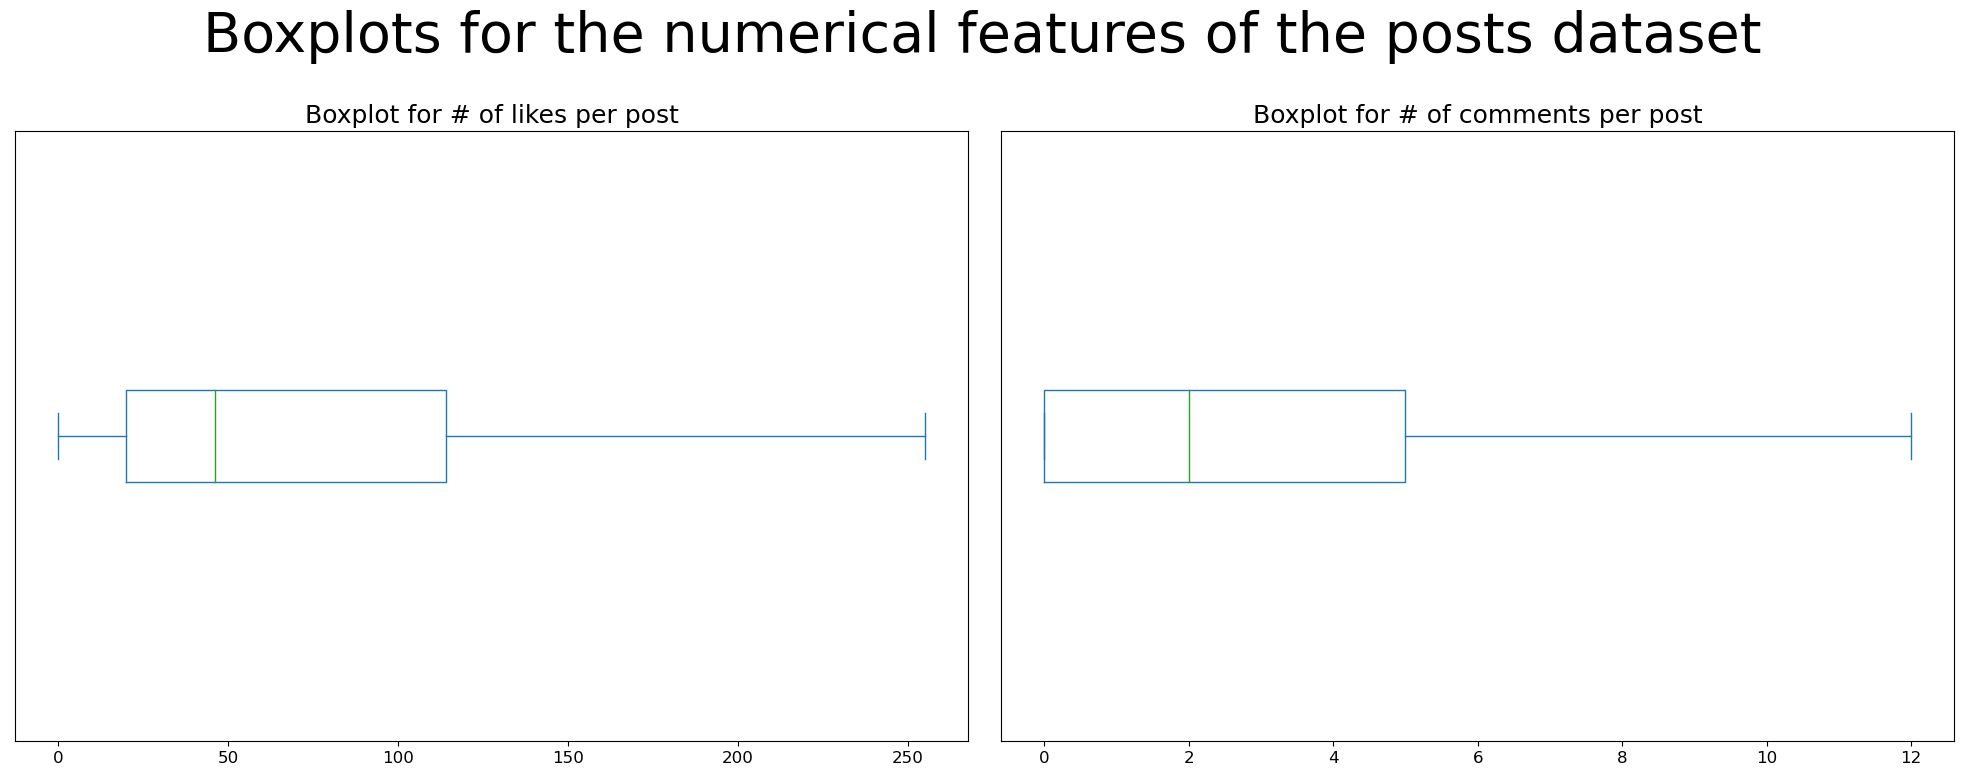

In [7]:
# Boxplot numerical of posts
plt.figure(figsize=(20, 8))
ax = plt.subplot(1, 2, 1)
posts["numbr_likes"].plot.box(showfliers=False, vert=False, ax=ax, fontsize = "large")
ax.axes.get_yaxis().set_visible(False)
ax.set_title("Boxplot for # of likes per post", {"fontsize":18})
ax = plt.subplot(1, 2, 2)
posts["number_comments"].plot.box(showfliers=False, vert=False, ax=ax, fontsize = "large")
ax.axes.get_yaxis().set_visible(False)
ax.set_title("Boxplot for # of comments per post", {"fontsize":18})
plt.suptitle("Boxplots for the numerical features of the posts dataset", fontsize = 40)
plt.tight_layout(pad = 2)
plt.show()

 Another way would be to plot the histogram frequencies on a logarithmic scale. (an idea which was suggested by a colleague). An increase by one before the log-transformation was inserted to avoid the problem of the logarithm not defined in 0.

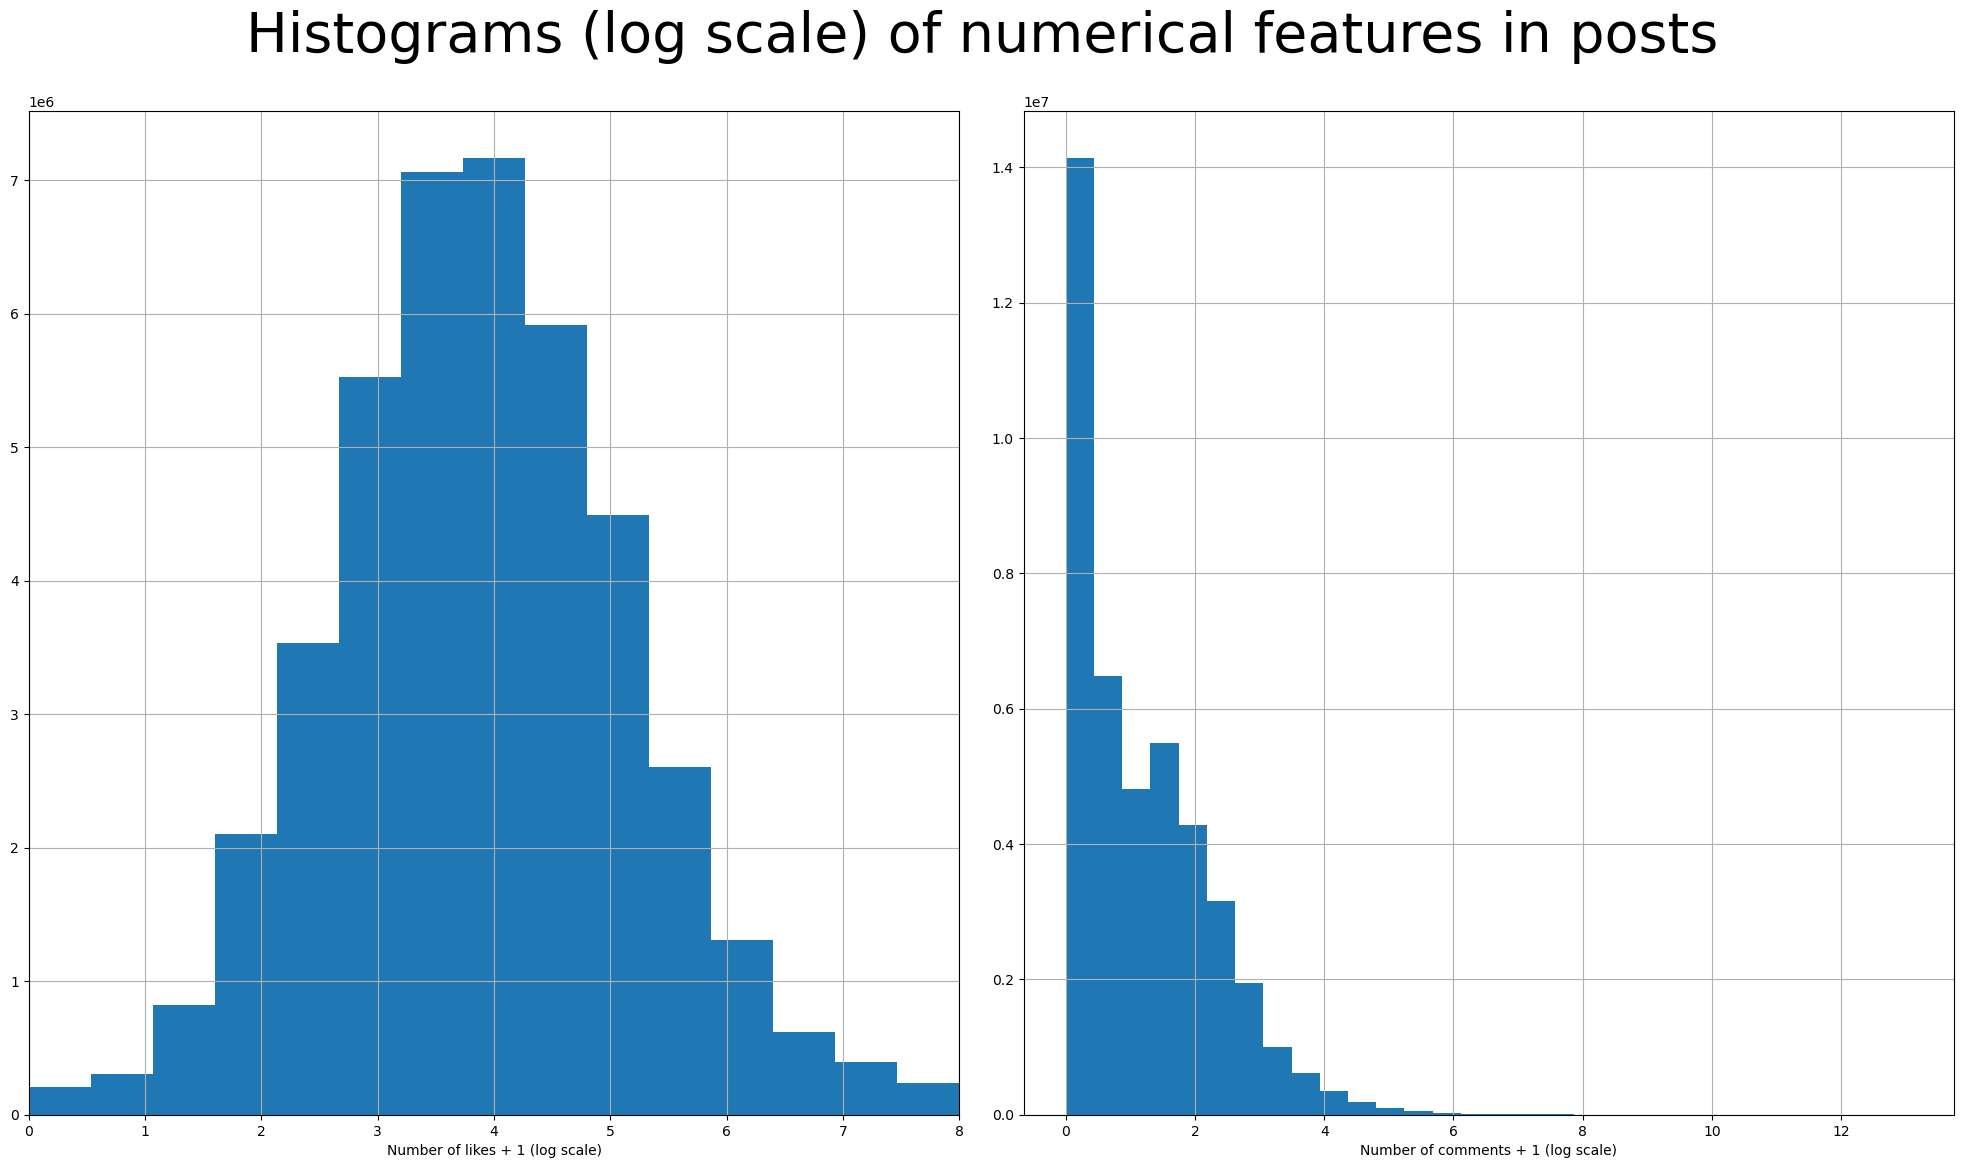

In [8]:
plt.figure(figsize=(20, 12))
ax = plt.subplot(1, 2, 1)
(posts["numbr_likes"]+1).apply(np.log).hist(ax = ax, bins = 30)
ax.set_xlabel("Number of likes + 1 (log scale)")
ax.set_xlim((0, 8))
ax = plt.subplot(1, 2, 2)
(posts["number_comments"]+1).apply(np.log).hist(ax = ax, bins = 30)
ax.set_xlabel("Number of comments + 1 (log scale)")
plt.suptitle("Histograms (log scale) of numerical features in posts", fontsize = 40)
plt.tight_layout(pad = 2)
plt.show()

 It seems that the distribution of likes is approximately log-normal, i.e. the logarithm of the number of likes is normally distributed. A way to test this would be a quantile-quantile plot. Let's plot that.

From the plot, we can see that it definitely seems log-normal. The quantiles of the (standardized) sample distribution of the log number of likes almost perfectly match the ones of a standard normal.


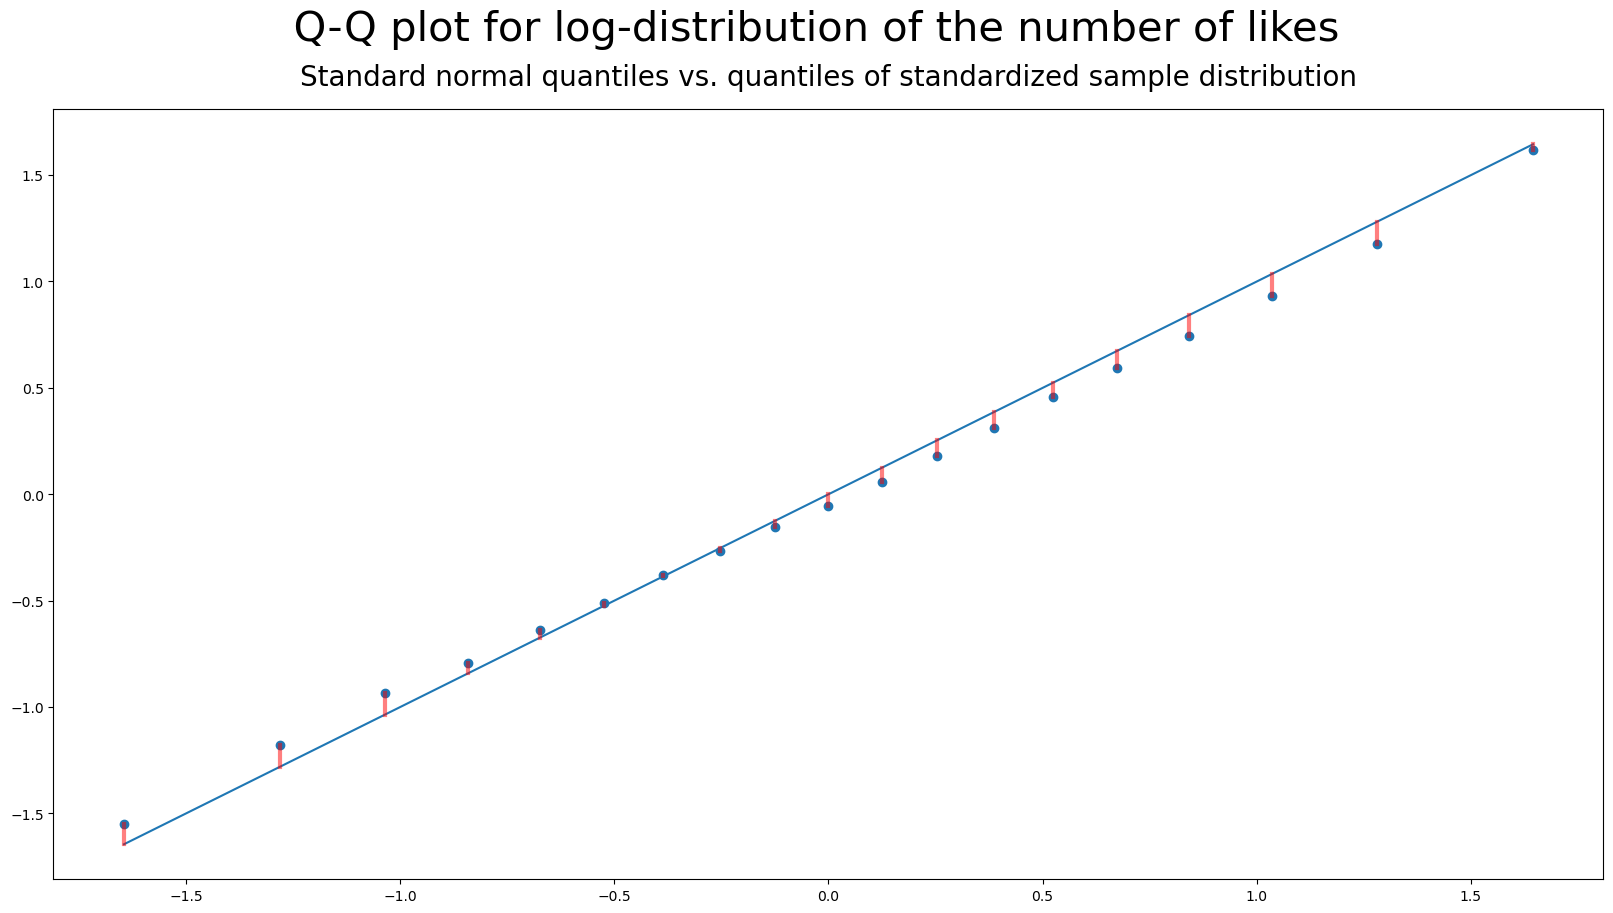

In [9]:
quantiles_stdnorm = [stats.norm.ppf(x) for x in np.arange(0.05, 0.96, 0.05)]

log_transformed_likes = (posts["numbr_likes"]+1).apply(np.log)
sample_quantiles_likes = ((log_transformed_likes-log_transformed_likes.mean())/log_transformed_likes.std()).quantile(np.arange(0.05, 0.96, 0.05))


plt.figure(figsize=(20, 10))
plt.suptitle("  Q-Q plot for log-distribution of the number of likes", fontsize = 30)
plt.title("Standard normal quantiles vs. quantiles of standardized sample distribution", fontsize = 20, y = 1.02)
ax = plt.gca()
ax.plot(quantiles_stdnorm, quantiles_stdnorm)
ax.scatter(quantiles_stdnorm, sample_quantiles_likes)
for standard, sample in zip(quantiles_stdnorm, sample_quantiles_likes):
    ax.plot([standard, standard], [standard, sample], c = "red", alpha = 0.5, linewidth = 3)
plt.show()

 At this point, in this preliminary EDA, a cool stuff that we can do is plotting the mean number of posts per weekday. We can do that quite easily by counting the observations with the weekday as _grouping key_ and then normalizing the count with the number of weeks in the dataset.

As one could expect, the weekend sees the number of posts skyrocketing (less working hours, more trips/holidays, stronger presence of the users online).

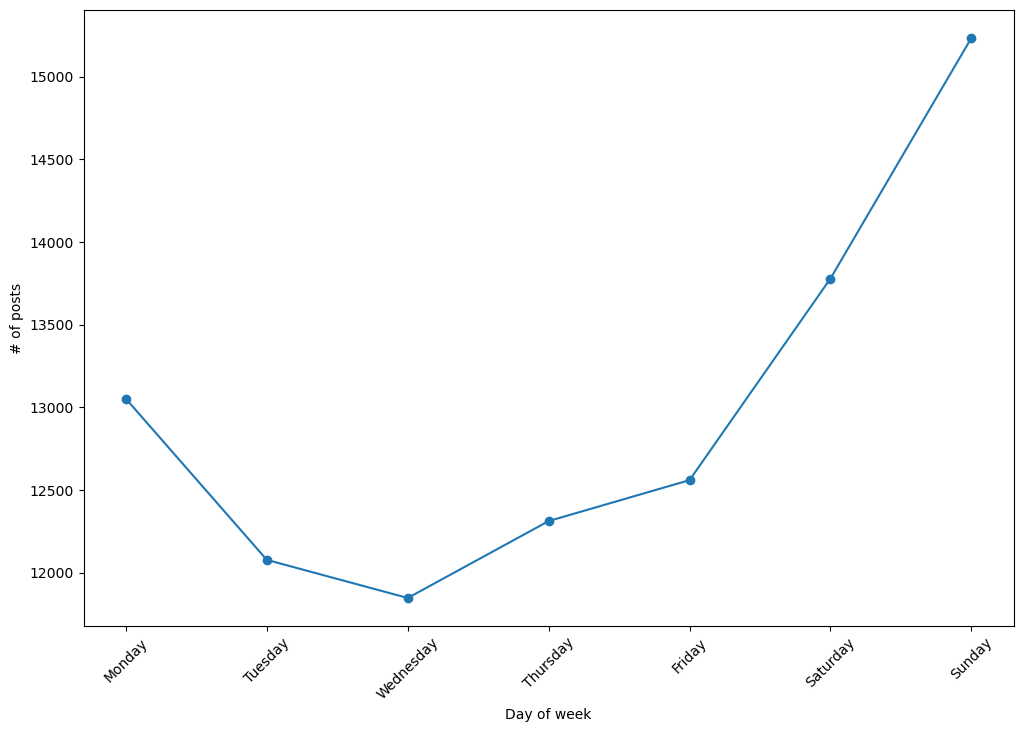

In [10]:
plt.figure(figsize = (12, 8))
number_of_weeks = len(posts["cts"].dt.isocalendar().iloc[:, 0:2].drop_duplicates())
grouped_dayweek_post = posts.groupby(posts["cts"].dt.dayofweek)
week_list = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
count_week = grouped_dayweek_post["sid"].count().set_axis(week_list)
# This normalizes the number of posts giving us the mean number post for each day (across the years)
count_week /= number_of_weeks
count_week.plot(marker="o")
plt.xlabel("Day of week")
plt.ylabel("# of posts")
plt.xticks(rotation=45)
plt.show()

### Features of the _profiles_ dataset
<a id="rq1.2"></a>

 Again, as we did before, let's recap the columns in the table:
 - _sid_ is the key which is used as reference for the foreign key in _posts_
 - profile_id is another id (the Instagram one).
 - profile_name nomen omen.
 - _firstname_lastname_ nomen omen.
 - _description_ is the description of the profile. Looking at the actual strings, it is the "bio" of the profile.
 - _following_ is the number of accounts followed by the users.
 - _followers_ is the number of accounts which follow the user.
 - _n_posts_ is the number of posts published by the user.
 - _url_ is the URL highlighted in the profile under the description/bio.
 - _cts_ is the timestamp for the time when the data of the profile was scraped.
 - _is_business_account_ is a boolean to check if the profile is a business account or not.

In [11]:
print(profiles.columns.values)

['sid' 'profile_id' 'profile_name' 'firstname_lastname' 'description'
 'following' 'followers' 'n_posts' 'url' 'cts' 'is_business_account']


The only numerical columns here are _following_, _followers_ and _n_posts_. We look at their distribution by printing summary statistics and drawing some boxplots (excluding the outliers) and histograms.

Especially for what concerns the followers, what we see is basically the quintessence of what we explained in the [previous point](#graph_theory_pref) of this question. However, since [RQ8](#rq8) specifically deals with the followers' distribution, we will not go in depth with that now.

Let's jump to the number of posts for the moment. The distribution for the number of posts seems far less distorted than the one of followers (or than the one of likes), and this is because the number of posts is not something **strictly** related to the popularity of the user, which is in turn modelled by a preferential attachment process. Again, this is intuitive: a user may enjoy interacting with its relatively small subset of followers and publish a lot, maybe at the same or at a similar rate of an influencer.

This is also highlighted, as can be seen from one of the histograms below, by the fact that the number of posts does not seem to be log-normally distributed, since the log-distribution is definitely left-tailed.

The distortion (anyway strongly present) highlighted by skewness and kurtosis can be easily explained (at least in part) by the fact that a social network is full of _zombie accounts_: bots, inactive users and people subscribing just to follow other people.

In [12]:
# Basic summary statistics for profiles
# print(profiles.describe().iloc[1:, 2:].drop("min", axis = 0).to_markdown(), end = "\n\n")

print("Skewness for # of posts distro: {}".format(round(profiles["n_posts"].skew(), 2)))
print("Excess kurtosis for # of posts distro: {}".format(round(profiles["n_posts"].kurtosis(), 2)))

Skewness for # of posts distro: 21.8
Excess kurtosis for # of posts distro: 1510.84


|      |      following |        followers |    n_posts |
|:-----|---------------:|-----------------:|-----------:|
| mean | 1405.64        |   4739.9         |    409.541 |
| std  | 8113.47        | 193909           |   1041.94  |
| 25%  |  356           |    159           |     22     |
| 50%  |  754           |    406           |    120     |
| 75%  | 1573           |    974           |    420     |
| max  |    4.19108e+06 |      2.85458e+08 | 183730     |


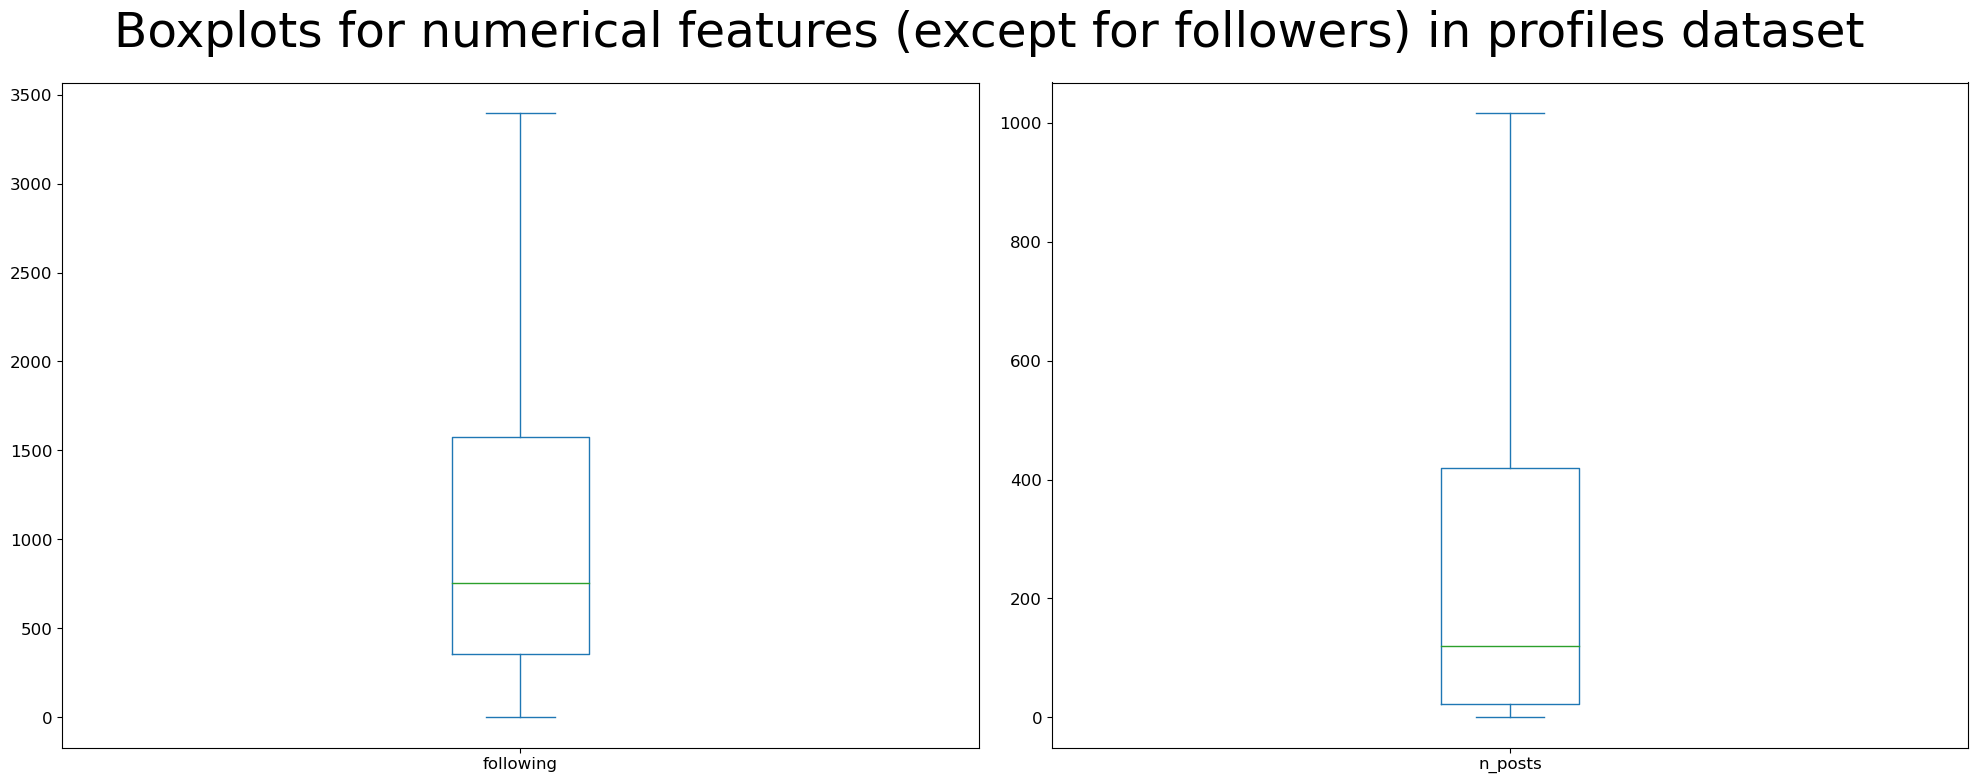

In [13]:
# Boxplots of numerical features in profiles (-followers)
plt.figure(figsize=(20, 8))
ax = plt.subplot(1, 2, 1)
profiles[["following"]].plot.box(showfliers=False, fontsize = "large", ax = ax)
ax = plt.subplot(1, 2, 2)
profiles[["n_posts"]].plot.box(showfliers=False, fontsize = "large", ax = ax)
plt.suptitle("Boxplots for numerical features (except for followers) in profiles dataset", fontsize = 35)
plt.tight_layout(pad = 1.5)
plt.show()

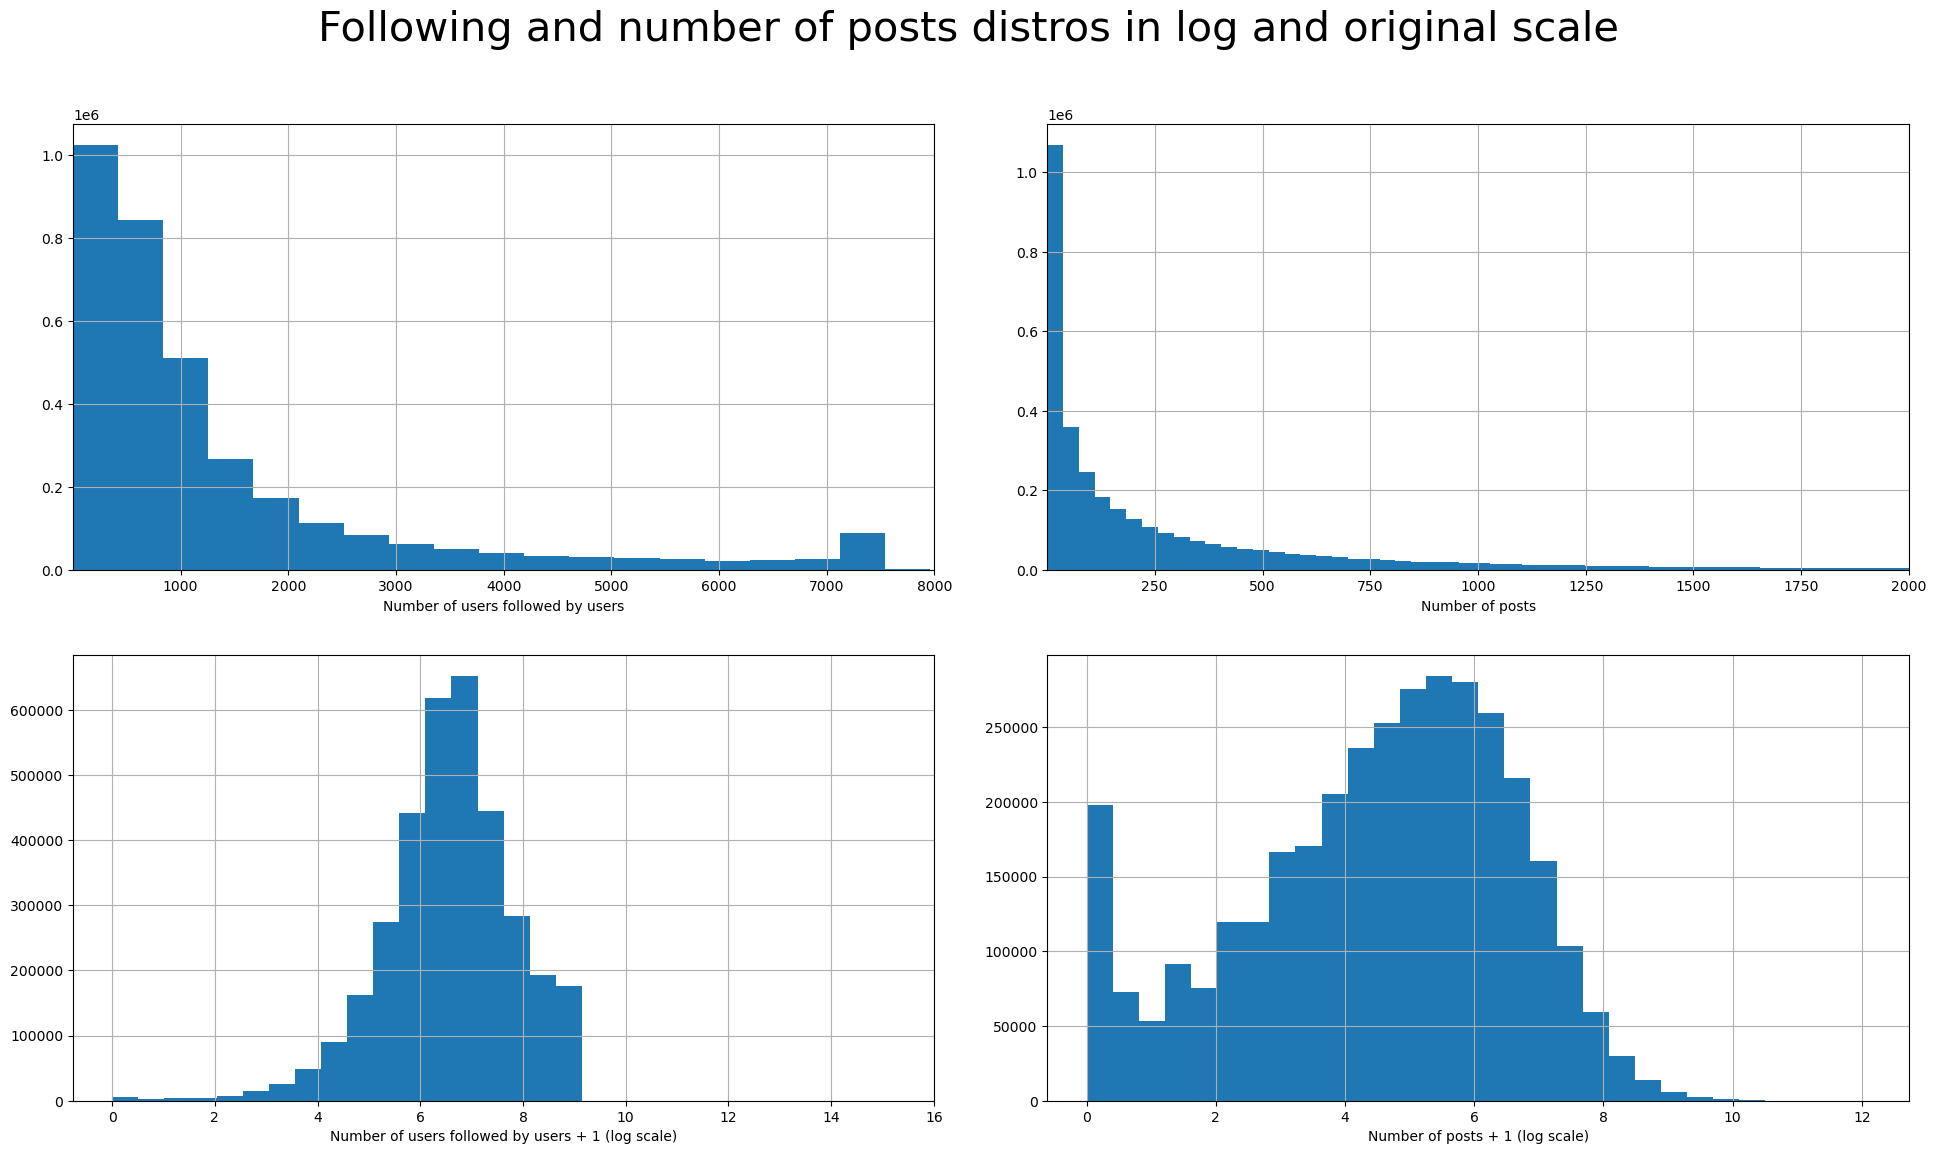

In [14]:
# Histograms

plt.figure(figsize=(20, 12))
ax = plt.subplot(2, 2, 1)
profiles.following.hist(ax = ax, bins = 10000)
ax.set_xlim((1, 8000))
ax.set_xlabel("Number of users followed by users")
ax = plt.subplot(2, 2, 2)
profiles.n_posts.hist(ax = ax, bins = 5000)
ax.set_xlim((1, 2000))
ax.set_xlabel("Number of posts")
ax = plt.subplot(2, 2, 3)
(profiles["following"]+1).apply(np.log).hist(ax = ax, bins = 30)
ax.set_xlabel("Number of users followed by users + 1 (log scale)")
ax = plt.subplot(2, 2, 4)
(profiles["n_posts"]+1).apply(np.log).hist(ax = ax, bins = 30)
ax.set_xlabel("Number of posts + 1 (log scale)")
plt.suptitle("Following and number of posts distros in log and original scale", fontsize = 30)
plt.tight_layout(pad = 3)
plt.show()

### Plotting the _locations_ dataset
<a id="rq1.3"></a>

The _locations_ dataset is purely geographical data, and probably the best way to plot it is by using a world map.

Before continuing, we check the presence of missing values for what concerns latitude and/or longitude. The 0.6% of the locations does not have geographic coordinates, this means that we have a lot of data for the plot!

Notice also that the original dataset has latitude in place of the longitude, and viceversa, so we need to swap the two, [as I wrote on Kaggle](https://www.kaggle.com/datasets/shmalex/instagram-dataset/discussion/361643) for the other colleagues to notice.

The naive way would be to just plot each of the locations as a point in a world map. Spoiler: this results in a textbook case of overplotting. We cannot understand anything because the number of points scattered is too high.

In [15]:
assert locations.lng.isna().sum() == locations.lat.isna().sum()
print(f"Missing coordinates (percentage): {round(locations.lng.isna().sum()/len(locations), 5)}")

locations["lat"], locations["lng"] = locations["lng"], locations["lat"]

Missing coordinates (percentage): 0.00603


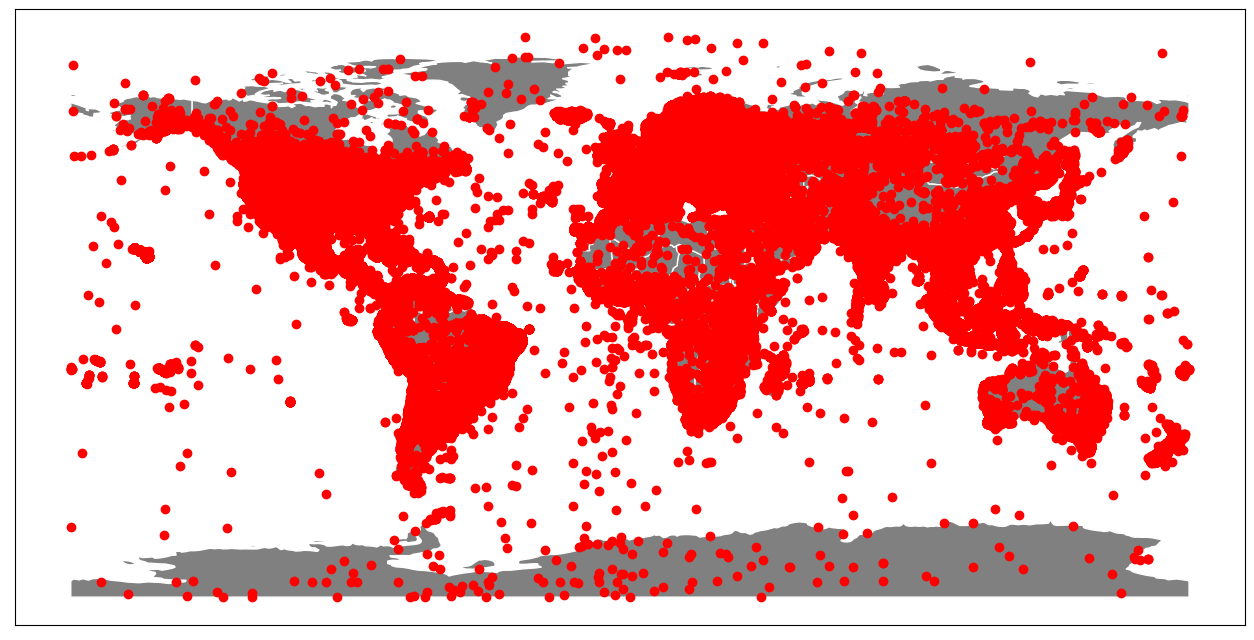

In [16]:
plt.figure(figsize=(17, 8))
ax = plt.gca()
world = geopd.read_file(geopd.datasets.get_path("naturalearth_lowres"))
world.plot(color="gray", edgecolor = "white", ax = ax)
plt.sca(ax)
plt.scatter(locations["lng"], locations["lat"], color = "red")
plt.xticks([])
plt.yticks([])
plt.show()

How can we solve this? The simplest and probably the most effective way is clustering the data and plotting just the centroids, keeping the information concerning the size of each cluster. There are different ways to do clustering, the simplest is probably **K-means**, clustering the points in the $\mathbb{R}^2$ space given by latitude and longitude.

To do this, we use scikit-learn. The hyperparameters which are set are, more or less arbitrarily:
- 100 is set as the number of initialized centroids and thus of the resulting number of clusters.
- 10 is set as the number of different initializations of the centroids (the best one in terms of the final intra-cluster variance is chosen as the best).
- 50 is set as the maximum number of iterations for the algorithm.
- Tolerance is set to 0. This is the (relative) tolerance with respect to the Frobenius norm of the difference in the centroids between two consecutive iterations. This hyperparameter set to 0 means that the algorithm needs to find a strict convergence in order to stop before the maximum number of iterations.


At first glance, the plot (the position and the size of the points/the centroids) allows use to notice that most of the locations in the _locations_ table are concentrated in the United States and in Europe, with some relevant clusters also in South America, western Russia (which indeed accounts for about 75% of Russia's population), India, Indonesia, Japan, Thailand and southern Australia (around Melbourne and Sydney). I hope that I did not make mistakes geography-wise...

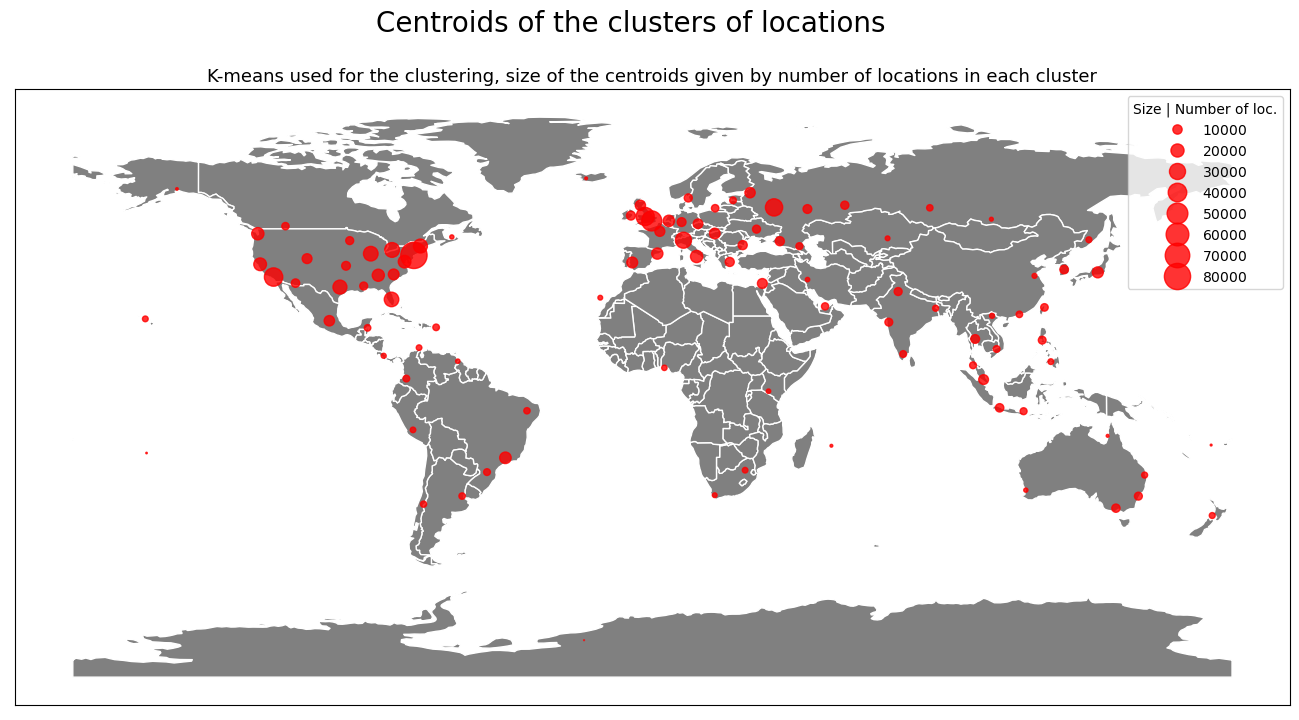

In [17]:
# K-means clustering with scikit
kmeans_fit = clustering.KMeans(n_clusters=100, verbose=0, n_init=10, random_state=123, max_iter=50, tol = 0).fit(locations[["lng", "lat"]].dropna())

# Get centroids, get number of observations for each cluster (will be used as size of the point)
centroids = kmeans_fit.cluster_centers_
_ , weights = np.unique(kmeans_fit.labels_, return_counts=True)
geocluster_df = pd.DataFrame(centroids, columns = [["lng", "lat"]])
standardization_factor_positions = np.std(weights)
geocluster_df["weights"] = weights/standardization_factor_positions*50

# Plot
plt.figure(figsize=(17, 8))
ax = plt.gca()
world.plot(color="gray", edgecolor = "white", ax = ax)
plt.sca(ax)
scatter_plot = plt.scatter(geocluster_df.iloc[:, 0], geocluster_df.iloc[:, 1], color = "red", alpha = 0.8, s = geocluster_df["weights"])
plt.xticks([])
plt.yticks([])

handles, labels = scatter_plot.legend_elements(prop="sizes", alpha=0.8, color="red", func = lambda x: x*standardization_factor_positions/50)

plt.legend(handles, labels, title = "Size | Number of loc.")
plt.suptitle("Centroids of the clusters of locations", fontsize = 20)
plt.title("K-means used for the clustering, size of the centroids given by number of locations in each cluster", fontsize = 13)
plt.show()

## RQ2
<a id = "rq2"></a>

### 2.1 Plot the number of posts for each profile in descending order
<a id = "rq2.1"></a>

We remove the observations with a missing value in place of the number of posts. We cannot say anything about them for this question.

In [3]:
print("These are the number of posts for each profile in descending order.")
display(profiles[["profile_id", "n_posts"]].dropna().sort_values(by=['n_posts'], ascending = False))

These are the number of posts for each profile in descending order.


,profile_id,n_posts
3990313,1.996648e+08,183730.0
2571453,8.563367e+09,142428.0
4338921,1.273455e+09,126340.0
3942129,9.813508e+06,125220.0
4219642,1.607309e+09,117262.0
...,...,...
1113624,3.278989e+09,0.0
3589031,1.025278e+10,0.0
2475993,2.043011e+09,0.0
3589011,2.882129e+08,0.0


### 2.2 What posts have the highest number of “likes”?
<a id = "rq2.2"></a>

In [21]:
print("These are the 10 posts with the highest number of likes:")
display(posts.drop(["description", "cts"], axis = 1).dropna(subset = "numbr_likes").sort_values(by="numbr_likes", ascending = False).head(10))

These are the 10 posts with the highest number of likes:


,sid,sid_profile,post_id,profile_id,location_id,post_type,numbr_likes,number_comments
19624085,4768909,531404,Bt3yaXmAM0d,4.906778e+07,NaN,1,8822952.0,165886.0
19623988,4768904,531404,BuwffB7g8cK,4.906778e+07,NaN,1,5447066.0,25303.0
19624082,4768906,531404,Buc1gyZAaMQ,4.906778e+07,NaN,1,5116398.0,40608.0
19623986,4768902,531404,BvcukE8AMuG,4.906778e+07,NaN,1,4271466.0,30770.0
39701024,25302472,470575,BqSLFVBFLfq,4.275539e+08,3.214182e+14,1,4264745.0,18691.0
6293907,34909573,327444,BwTSXBKg7gN,1.518284e+09,1.498995e+15,1,3586546.0,15405.0
19624086,4768910,531404,Btw8pFXAvQm,4.906778e+07,NaN,1,3558599.0,15715.0
19802016,4935518,397587,BvC3n6_gqin,2.153681e+09,NaN,1,3533326.0,59475.0
30850564,15431581,3520880,Bw7vqLrFkHi,2.031501e+07,NaN,1,3340297.0,149489.0
39812576,25415502,91738,Bw2gTH1AiDA,3.530696e+07,NaN,1,3311246.0,64318.0


### 2.3 What posts have the most and the least number of comments?
<a id = "rq2.3"></a>

In [6]:
posts_ordered_com = posts.drop(["description", "cts"], axis = 1).dropna(subset="number_comments").sort_values(by=['number_comments'], ascending = False)
print("These are the 10 posts with the most comments: ")
display(posts_ordered_com.head(10))
print("These are the 10 posts with the lowest number of comments: ")
display(posts_ordered_com.tail(10))
del posts_ordered_com

These are the 10 posts with the most comments: 


,sid,sid_profile,post_id,profile_id,location_id,post_type,numbr_likes,number_comments
41873060,27503892,-1,Bx2sPAjHviO,1.635670e+09,2.440002e+08,1,38871.0,488953.0
12164781,39701672,3940995,BuGjhWAhAW5,4.282994e+08,NaN,1,81523.0,313997.0
33261751,9952351,3335216,BJ-rkpTgn1N,5.533645e+07,3.753146e+08,1,54507.0,257488.0
11149127,22594279,3831202,BMtisIxjhtT,5.697152e+06,2.772223e+14,1,331703.0,214365.0
9383817,37533033,3637382,BzOOWj3DfZK,1.062916e+09,NaN,1,23515.0,189888.0
5427268,34001623,3420057,BoQoM-JFkPA,1.440949e+08,1.834001e+14,1,129258.0,180635.0
25257169,17140508,2156149,Bwarws1lCok,1.666815e+07,NaN,1,684861.0,173988.0
6220011,34832893,468168,Bt4qlVDAZMH,1.797807e+08,1.090107e+15,1,2224495.0,170836.0
31689573,16275118,2035256,Bs9NhQkAcJA,6.760538e+06,NaN,1,226336.0,166919.0
14257307,41532500,4261744,Bzqb95QI_1E,1.959418e+08,2.439160e+08,1,169791.0,166198.0


These are the 10 posts with the lowest number of comments: 


,sid,sid_profile,post_id,profile_id,location_id,post_type,numbr_likes,number_comments
10727132,38579660,3783269,Bx5XAzDHUe7,2.701312e+08,NaN,1,36.0,0.0
29592201,14191065,-1,BxIenYFnmAu,1.793258e+09,1.583495e+14,1,17.0,0.0
29592204,14191075,-1,Bw69L_ollho,5.706689e+09,1.583495e+14,2,9.0,0.0
29592205,14191079,-1,Bw5K1oGjIK4,1.121288e+10,1.583495e+14,2,1120.0,0.0
10727121,38579714,3783282,BzQkgAUpp-y,3.044875e+08,2.210143e+08,1,83.0,0.0
10727119,38579640,3783265,BohcyBgFtD6,3.062077e+09,NaN,1,16.0,0.0
10727117,38579630,3783265,BqEZ-DRFCy8,3.062077e+09,4.210424e+14,1,29.0,0.0
10727106,38579626,3783268,BzaQtxKJPci,1.714050e+09,NaN,1,31.0,0.0
10727103,38579827,3783292,BzdFSh-nONl,1.041386e+10,3.775281e+08,1,5.0,0.0
0,28370919,3496776,BXdjjUlgcgq,2.237948e+09,1.022366e+15,2,80.0,0.0


### 2.4 How many posts include tagged locations, and how many do not? Show it using an appropriate chart and comment your results?
<a id = "rq2.4"></a>

The number of posts that include tagged locations is:  29737425
The number of posts that DO NOT include tagged locations is:  12972772


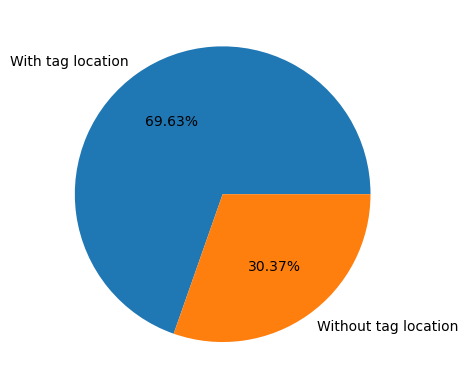

In [4]:
tag_loc = posts[~ posts["location_id"].isna()].shape[0]
no_tag_loc = posts.shape[0]- tag_loc
print("The number of posts that include tagged locations is: ",tag_loc)
print("The number of posts that DO NOT include tagged locations is: ",no_tag_loc)
y = np.array([tag_loc, no_tag_loc])
my_labels = ["With tag location", "Without tag location"]
plt.pie(y,labels = my_labels, autopct='%1.2f%%')
plt.show()

### 2.5 How many posts include only photos? How many also have videos?
<a id = "rq2.5"></a>

In [5]:
print("The number or posts that include only photos is: ",posts[posts["post_type"]==1].shape[0])
print("The number or posts that include only videos is: ",posts[posts["post_type"]==2].shape[0])
print("The number or posts that include both photos and videos: ",posts[posts["post_type"]==3].shape[0])

The number or posts that include only photos is:  41534486
The number or posts that include only videos is:  1134768
The number or posts that include both photos and videos:  40943


### 2.6 What’s the percentage of business accounts vs non-business? What can you interpret regarding that percentage?
<a id = "rq2.6"></a>

Since we are computing the percentage of business accounts vs. non-business accounts, it does not make sense to consider observations with NAs in that field.

The percentage of business accounts is:  0.25
The percentage of NON-business accounts is:  0.75


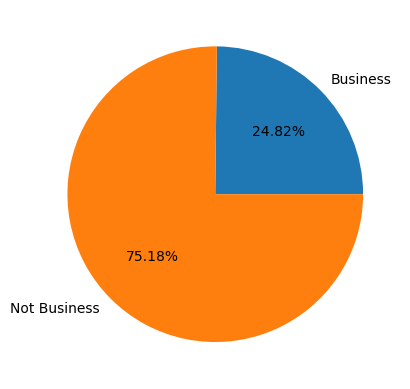

In [19]:
not_na_business = len(profiles.dropna(subset = "is_business_account"))
percentage_bus_acc = profiles.is_business_account.sum()
percentage_NONbus_acc = not_na_business-percentage_bus_acc
percentage_bus_acc /= not_na_business
percentage_NONbus_acc /= not_na_business
print("The percentage of business accounts is: ", round(percentage_bus_acc, 2), sep = " ")
print("The percentage of NON-business accounts is: ", round(percentage_NONbus_acc, 2), sep = " ")
y = np.array([percentage_bus_acc,percentage_NONbus_acc])
mylabels = ["Business", "Not Business"]
plt.pie(y,labels = mylabels, autopct='%1.2f%%')
plt.show()

For what we can observe the **business option** is really significant: almost 25% of the users have this type of profile (the percentage may even be higher since we don't know how many of the users are bot, fake or disused account).

We can interpret this as a confirmation that currently Instagram is seen as a powerful marketing medium (as all social media platforms).
This means that many profiles use Instagram as a tool to gain profits and to perform marketing activities.

## RQ3
<a id = "rq3"></a>

### 3.1 Most common time in which users publish their posts
<a id = "rq3.1"></a>

 This is pretty straightforward to do, but it should be stressed that we have no information from the dataset for what concerns the timezones, which is a quite crucial bit of information.

The timestamps probably refer to a single timezone, so it is difficult to talk about the "most common time", since to check something like this we should have the timestamps relatively to the timezone of the account which posted.

 Considering the limitation, let's answer the question.

| hour | relative number of obs. |
|-----:|:------------------------|
|    0 | 3.62%                   |
|    1 | 3.22%                   |
|    2 | 3.02%                   |
|    3 | 2.88%                   |
|    4 | 2.66%                   |
|    5 | 2.45%                   |
|    6 | 2.37%                   |
|    7 | 2.56%                   |
|    8 | 2.97%                   |
|    9 | 3.36%                   |
|   10 | 3.68%                   |
|   11 | 4.03%                   |
|   12 | 4.38%                   |
|   13 | 4.74%                   |
|   14 | 5.06%                   |
|   15 | 5.3%                    |
|   16 | 5.48%                   |
|   17 | 5.68%                   |
|   18 | 5.82%                   |
|   19 | 5.85%                   |
|   20 | 5.84%                   |
|   21 | 5.65%                   |
|   22 | 5.08%                   |
|   23 | 4.3%                    |

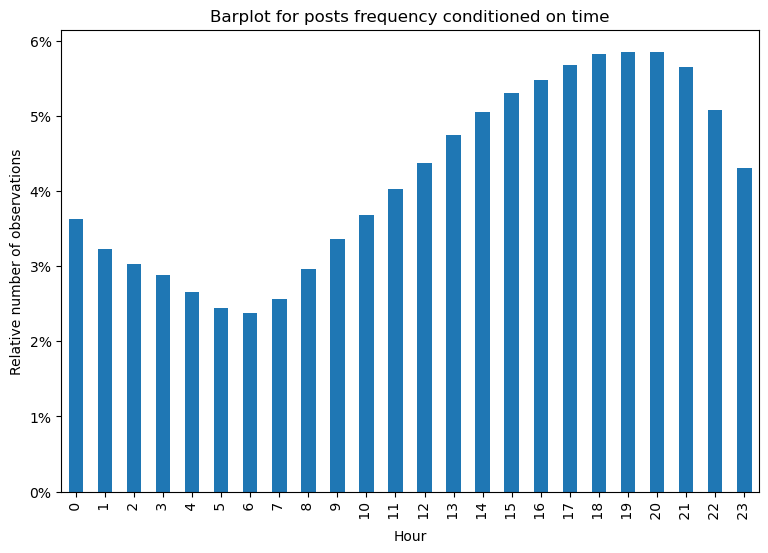

In [27]:
# print(((posts.cts.dt.hour.value_counts(True)*100).sort_index()).round(2).astype("str").add("%").to_markdown())
plt.figure(figsize=(9, 6))
posts.cts.dt.hour.value_counts(True).sort_index().plot.bar()
plt.xlabel("Hour")
plt.ylabel("Relative number of observations")
plt.title("Barplot for posts frequency conditioned on time")
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('% .0f'))
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.show()
# The time range which seems more active is the one from early-mid afternoon to 9/10 PM.

According to the plot above, the time range which seems more active is the one from early-mid afternoon to 9/10 PM.

### 3.2 Define the function which receives time intervals and plots the number of posts for each time interval
<a id = "rq3.2"></a>

In [18]:
def time_interval_obs(interval_list: list[tuple[str | time, str | time]], time_df: pd.DataFrame, time_col: str | None = None) -> None:
    if not time_col:
        dtypes_series = time_df.dtypes.index[time_df.apply(pd.api.types.is_datetime64_any_dtype)]
        if dtypes_series.empty:
            raise ValueError(
                "The dataframe has no columns for time, you need to pass a dataframe which has at least one")
        elif len(dtypes_series) != 1:
            raise TypeError("The dataframe has more than one column with datetime 64 dtype.\n\
                            You need to explicitly tell the function which one to use")
        else:
            time_col = dtypes_series[0]

    try:
        time_df = pd.Series(np.zeros(len(time_df))).set_axis(time_df[time_col])
    except KeyError:
        raise KeyError("The column you specified does not exist in the dataframe")

    n_posts_int_list = [len(time_df.between_time(*interval)) for interval in interval_list]

    plt.figure(figsize=(13, 7))
    if all([isinstance(x, time) for couple in interval_list for x in couple]):
        interval_list = [[str(x) for x in y] for y in interval_list]
        plt.bar(["|".join(x) for x in interval_list], n_posts_int_list)
    elif all([isinstance(x, str) for couple in interval_list for x in couple]):
        plt.bar(["|".join(x) for x in interval_list], n_posts_int_list)
    else:
        raise TypeError("The inserted interval list needs to have elements (the extremes of each interval) of type datetime.time or string")
    plt.xlabel("Time Interval")
    plt.ylabel("Number of posts")
    plt.xticks(rotation=20)
    plt.show()

    return None

### 3.3 Plot the number of posts for the given time intervals
<a id = "rq3.3"></a>

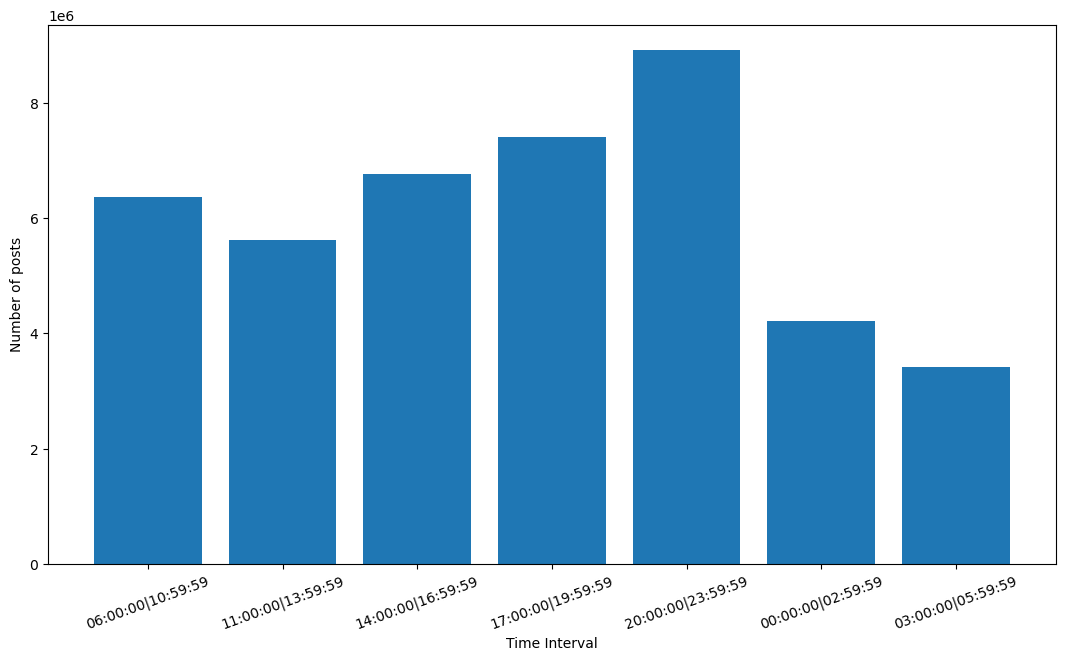

In [32]:
test_list = [("06:00:00", "10:59:59"), ("11:00:00","13:59:59"), ("14:00:00", "16:59:59"), ("17:00:00", "19:59:59"), ("20:00:00", "23:59:59"), ("00:00:00", "02:59:59"), ("03:00:00", "05:59:59")]

time_interval_obs(test_list, posts)

## RQ4
<a id = "rq4"></a>



### 4.1 Write a function that, given a profile_id, will be able to return the posts that belong to the given _profile_id_
<a id = "rq4.1"></a>

In this function we need to pass the _profile_id_ of a profile, and it will return a DataFrame with all the posts published by this user. There is also an example in the next cell.

In [33]:
def return_posts(profile_id):
    posts_of_profile = posts[posts["profile_id"]==profile_id]
    return posts_of_profile

In [37]:
# Test
display(return_posts(11357330613))

,sid,sid_profile,post_id,profile_id,location_id,cts,post_type,description,numbr_likes,number_comments
13373495,40756452,4089853,B0EUIe6hurR,1.135733e+10,NaN,2019-07-18 20:01:37,1,CALENDAR PUPS - Be Part of our 2020 Cockapoo ...,38.0,4.0
13373496,40756453,4089853,ByumbfphdR2,1.135733e+10,NaN,2019-06-15 13:06:49,1,Do you like our new bathmat\n#cockapoosofinsta...,49.0,1.0
13373497,40756454,4089853,BxouTbwBmlP,1.135733e+10,7.865953e+08,2019-05-19 09:48:47,1,More pictures from the Tatton Walk - thank you...,59.0,6.0
13373498,40756455,4089853,BxosvS6B4k7,1.135733e+10,7.865953e+08,2019-05-19 09:35:07,1,Having a great time at the Tatton walk yesterd...,68.0,3.0
13373499,40756456,4089853,BxnSSCVh-RD,1.135733e+10,2.286079e+08,2019-05-18 20:24:41,1,Next walk organised in collaboration with Ches...,30.0,2.0
13373500,40756457,4089853,Bxl_tPzB_3P,1.135733e+10,7.865953e+08,2019-05-18 08:23:08,1,Have a great time Doodles\n\n#cockapoosofinsta...,31.0,4.0
13373501,40756458,4089853,BxCcz8BhJHH,1.135733e+10,NaN,2019-05-04 13:04:48,1,More outtakes - so funny #maythe4thbewithyou #...,50.0,0.0
13373502,40756459,4089853,BxCcoHMhbQW,1.135733e+10,NaN,2019-05-04 13:03:11,1,Star Wars Puppies and outtakes \n#maythe4thbew...,41.0,0.0
13373505,40756460,4089853,BxCTV6cBOHy,1.135733e+10,NaN,2019-05-04 11:42:03,1,Have a look at our competition over on FB \n#c...,65.0,2.0
13373506,40756461,4089853,Bw6WIOBhlfY,1.135733e+10,NaN,2019-05-01 09:32:29,1,Lovely Nico winner of our Easter Competition s...,47.0,1.0


### 4.2 Write another function that, given an input n (an integer), will return the posts that belong to the n top posted profiles.
<a id = "rq4.2"></a>

As before, a quick test is performed after the function definition.

In [44]:
def top_n_users(n):
    top_n_profiles = profiles.sort_values(by=['n_posts'], ascending = False).head(n)
    index = set(top_n_profiles.profile_id.tolist())
    new_dataset = posts[posts["profile_id"].isin(index)]
    return new_dataset.sort_values(by="profile_id",ascending=False)

In [45]:
print("An example with the top 3 profiles:")
top_n_users(3)

An example with the top 4 profiles:


,sid,sid_profile,post_id,profile_id,location_id,cts,post_type,description,numbr_likes,number_comments
24978956,9253755,3288809,BxJpeX2pXeN,8.563367e+09,2.196108e+08,2019-05-07 08:10:08,1,NaN,0.0,0.0
24979983,9253732,3288809,BxJp4i3pArJ,8.563367e+09,2.196108e+08,2019-05-07 02:13:42,1,NaN,0.0,0.0
24956847,9253738,3288809,BxJpvMrpl0n,8.563367e+09,2.196108e+08,2019-05-07 02:12:26,1,NaN,0.0,0.0
24979865,9253740,3288809,BxJptNSpk6g,8.563367e+09,2.196108e+08,2019-05-07 02:12:09,1,NaN,0.0,0.0
24979875,9253736,3288809,BxJpzW4J6Aq,8.563367e+09,2.196108e+08,2019-05-07 02:13:00,1,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
9592969,37701756,3661552,BzUmcZRpTTn,1.996648e+08,NaN,2019-06-30 07:18:05,1,NaN,3.0,0.0
9593158,37701769,3661552,BzScUjhJiwK,1.996648e+08,NaN,2019-06-29 11:11:09,1,NaN,17.0,0.0
9593159,37701783,3661552,BzRkojLJBMQ,1.996648e+08,NaN,2019-06-29 03:04:33,1,NaN,10.0,0.0
9593160,37701797,3661552,BzRkmb3JXea,1.996648e+08,NaN,2019-06-29 03:04:15,1,NaN,9.0,0.0


### 4.3 What is the average number of “likes” and comments of the top 10 profiles with the highest number of posts?
<a id = "rq4.3"></a>

In [54]:
top10_users= top_n_users(10)
print("average number of likes:", round(top10_users.numbr_likes.mean(), 3), sep = " ")
print("average number of comments:", round(top10_users.number_comments.mean(), 3), sep = " ")

average number of likes: 3.171
average number of comments: 0.034


,sid,sid_profile,post_id,profile_id,location_id,cts,post_type,description,numbr_likes,number_comments
24980073,9253877,3288809,BxJp6dVJvtO,8.563367e+09,219610759.0,2019-05-07 02:13:58,1,NaN,0.0,0.0
24979961,9253756,3288809,BxJpcZ0JRqN,8.563367e+09,219610759.0,2019-05-07 08:09:52,1,NaN,0.0,0.0
24980045,9253742,3288809,BxJpq3dppxY,8.563367e+09,219610759.0,2019-05-07 02:11:50,1,NaN,0.0,0.0
24979946,9253737,3288809,BxJpxSLp4rB,8.563367e+09,219610759.0,2019-05-07 02:12:43,1,NaN,0.0,0.0
24980074,9253743,3288809,BxJposzpeA7,8.563367e+09,219610759.0,2019-05-07 02:11:33,1,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
9238357,37420382,3621669,BzMi2brAOq9,9.813508e+06,NaN,2019-06-27 04:12:46,1,NaN,0.0,0.0
9238358,37420395,3621669,BzMiyhRgTe3,9.813508e+06,NaN,2019-06-27 04:12:14,1,NaN,0.0,0.0
9238359,37420407,3621669,BzMivvVgoWY,9.813508e+06,NaN,2019-06-27 04:11:51,1,NaN,0.0,0.0
9238360,37420418,3621669,BzMiowXAGd_,9.813508e+06,NaN,2019-06-27 04:10:54,1,NaN,0.0,0.0


As we can notice these profiles have a very poor average numbers of likes and comments. Probably these users are bots or people that published a lot of posts.

### 4.4 Plot the number of posts that these top 10 profiles have sent on Instagram in the given interval in question RQ3.
<a id = "rq4.4"></a>

We use again the function defined in [RQ3](#rq3.2).

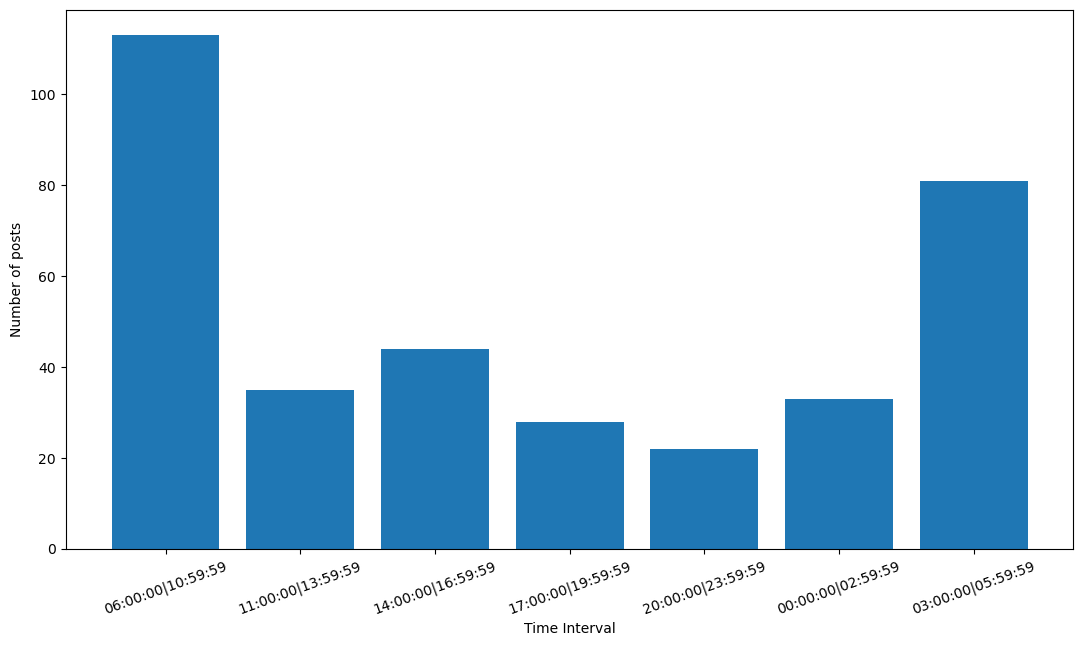

In [55]:
time_interval_obs(test_list, top10_users)

## RQ5
<a id ="rq5"></a>
### 5.1 Plot the top 10 most popular users in terms of followers and their number of posts
<a id ="rq5.1"></a>

,sid,profile_id,profile_name,firstname_lastname,description,following,followers,n_posts,url,cts,is_business_account
2880218,336492,2.502532e+07,instagram,Instagram,Bringing you closer to the people and things y...,226.0,285457645.0,5760.0,help.instagram.com,NaN,False
2582507,371414,3.416684e+06,victoriassecret,Victoria's Secret,Confidence is sexy. #wearitdaily,549.0,65269440.0,7355.0,like2b.uy/victoriassecret,NaN,True
3820939,337097,2.082449e+07,nba,NBA,"30 teams, 1 🏆\n👟: @nbakicks \n📽: @nbahistory \...",817.0,35339708.0,28816.0,nba.app.link/js6X7SVaxT,NaN,True
701965,330376,1.876191e+08,louisvuitton,Louis Vuitton Official,The official Instagram account of Louis Vuitton.,5.0,30689316.0,3352.0,on.louisvuitton.com/Like2Buy,NaN,True
2414951,292359,2.125507e+09,buzzfeedtasty,Tasty,"Recipes that will make you say ""oh yes!""\n👇 Cl...",298.0,30246783.0,2791.0,tasty.co/linkinbio,NaN,True
2785241,3437294,4.968651e+08,andresiniesta8,Andres Iniesta,"Andres Iniesta Official Instagram Account, \nB...",151.0,29542143.0,990.0,mikakus.com,2019-05-08 23:54:35.377 -0400,False
333193,158690,2.341008e+07,hm,H&M,Welcome to #HM! Follow us at @HM_Man @HM_Kids ...,403.0,29176804.0,4566.0,hm.info/1c9he,2018-05-31 19:33:46.022 -0400,True
3934581,3615154,2.423993e+07,princessyahrini,Syahrini,NaN,835.0,29042823.0,4719.0,www.youtube.com/c/ThePrincesSyahrini,2019-06-26 15:05:53.411 -0400,True
1311970,508140,5.041706e+07,danbilzerian,Dan Bilzerian,Snapchat: dbilzerian,252.0,26476004.0,1311.0,www.ignite.co,NaN,True
1703764,3513205,9.070254e+08,akshaykumar,Akshay Kumar,#AkshayKumar,5.0,26252169.0,1173.0,bit.ly/AliAliBlank,2019-05-14 08:29:29.754 -0400,False


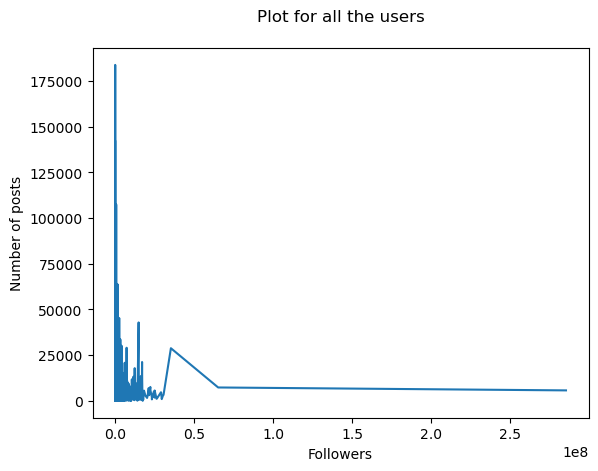

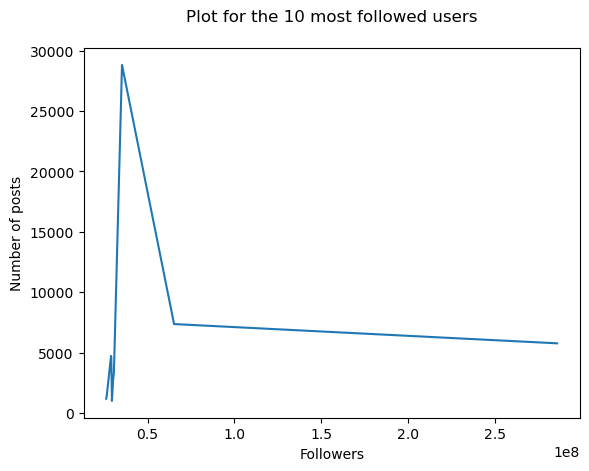

In [58]:
profiles_foll = profiles.sort_values(by='followers', ascending=False)
display(profiles_foll.head(10))
plt.title("Plot for all the users", y= 1.05)
plt.plot(profiles_foll.followers, profiles_foll.n_posts)
plt.xlabel('Followers')
plt.ylabel('Number of posts')
plt.show()
plt.title("Plot for the 10 most followed users", y= 1.05)
plt.plot(profiles_foll.head(10).followers, profiles_foll.head(10).n_posts)
plt.xlabel('Followers')
plt.ylabel('Number of posts')
plt.show()

Contrary to what we expected, a higher number of followers does not imply a higher number of posts. Higher numbers of posts published coincide with a lower amount of followers.
This can be an indicator of how top influencers prefer to publish less but with more quality. We should anyway take into account that the spike in the number of posts can be given by bots.

### 5.2 Who is the most influential user?
<a id = "rq5.2"></a>

In [67]:
display(profiles_foll.head(1))
print(f"Profile name:{profiles_foll.head(1).profile_name.values[0]}\nThe most followed user in the dataset is Instagram official profile!")

,sid,profile_id,profile_name,firstname_lastname,description,following,followers,n_posts,url,cts,is_business_account
2880218,336492,25025320.0,instagram,Instagram,Bringing you closer to the people and things y...,226.0,285457645.0,5760.0,help.instagram.com,NaN,False


Profile name:instagram
The most followed user in the dataset is Instagram official profile!


### 5.3 Have they posted anything with tagged locations?
<a id = "rq5.3"></a>

As we have done in [a point](#rq4.2) from RQ4, we define a function that returns all the posts of the top n profiles in terms of a metric, in this case the number of followers.

In [1]:
def top_n_users_followers(n):
    top_n_profiles = profiles.sort_values(by="followers", ascending = False).head(n)
    index = set(top_n_profiles.profile_id.tolist())
    new_dataset = posts[posts["profile_id"].isin(index)]
    return new_dataset.sort_values(by="profile_id",ascending=False)

Now that we have all the posts from the most influential profiles (i.e. those with the most followers), we can derive the location ids from each individual post.

In [11]:
locations_top = top_n_users_followers(10)["location_id"].value_counts().rename("count")

In [17]:
locations_top = locations.join(locations_top, on = "id", how = "inner")[["city", "count"]]

Then we can check how many posts (in general) have been published by the top 10 users with these top locations as location tag. We plot the resulting frequency.

In [20]:
locations_top.sort_values(inplace = True, by = "count", ascending = False)

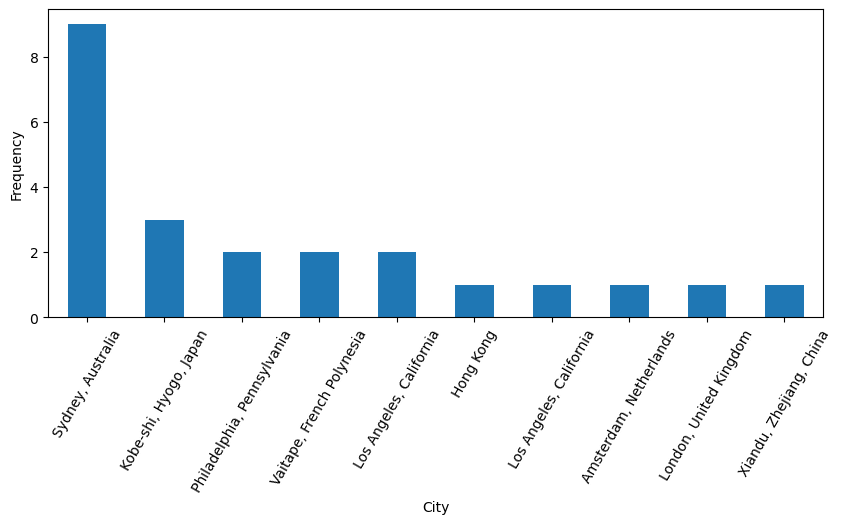

In [60]:
plt.figure(figsize = (10, 4))
locations_top.dropna(subset = "city").head(10).set_index("city").plot.bar(ax = plt.gca(), rot = 60, legend = False)
plt.xlabel("City")
plt.ylabel("Frequency")
plt.show()

### 5.4 How many pictures-only posts have they published? How many reels? (only videos) and how many with both contents?
<a id = "rq5.4"></a>

The percentage of posts that include only photos for the top users is:  91%
The percentage of posts that include only videos for the top users is:  9%
The percentage of posts that include both photos and videos for the top users is:  0%


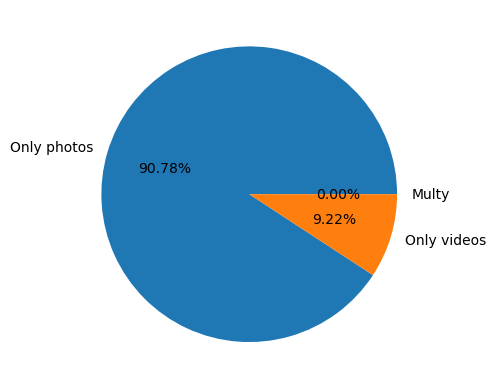

In [8]:
top = top_n_users_followers(10)
perc_photos = top[top["post_type"] == 1].shape[0] / top.shape[0]
perc_only_videos = top[top["post_type"] == 2].shape[0] / top.shape[0]
perc_multy = top[top["post_type"] == 3].shape[0] / top.shape[0]
print("The percentage of posts that include only photos for the top users is: ", str(round(perc_photos*100))+"%")
print("The percentage of posts that include only videos for the top users is: ", str(round(perc_only_videos*100))+"%")
print("The percentage of posts that include both photos and videos for the top users is: ", str(round(perc_multy*100))+"%")
y = np.array([perc_photos, perc_only_videos, perc_multy])
mylabels = ["Only photos", "Only videos", "Multy"]
plt.pie(y, labels=mylabels, autopct='%1.2f%%')
plt.show()

As we can notice, the great majority of posts published by the famous accounts are only with photos. Maybe the data was collected before the advent of _TikTok_, which increased the publication of video-only posts.

Photos may garner more engagement on platforms where users scroll through media quickly, while videos may be more successful on platforms where users are actively seeking out specific or detailed content. So it makes sense that users on Instagram prefer to publish posts with only pictures.

## RQ6
<a id = "rq6"></a>

### 6.1 What is the average time (days and minutes) a user lets pass before publishing another post? Plot the top 3 users that publish posts most frequently.
<a id = "rq6.1"></a>

 I spoke with another colleague, and it came up the fact that we could exploit the fact the average change in a signal is just the value at an extreme minus the value at the other extreme divided by the length of the signal minus 1. This is trivial to prove.

Since we need to calculate the average on the overall dataset, without caring about profile-specific data, we can just use _profile_id_ as row identifier (thus including also profiles which are not included in the _profiles_ dataset).

A bit of basic sexagesimal calculus is needed to get the average time in the right format (days, hours, minutes).

In [9]:
differences_array = posts[['profile_id', "cts"]].groupby('profile_id').max()-posts[['profile_id', "cts"]].groupby('profile_id').min()
differences_array["count"] = posts['profile_id'].value_counts() # Here the indexing of differences_array (the profile_id) is used for the alignment
differences_array = differences_array[differences_array["count"] != 1]
differences_array["cts"] /= differences_array["count"]-1
avg_timedelta = differences_array["cts"].mean()
# Basic sexagesimal calculus to get the right format, i.e. days/hours/minutes (3600 seconds in an hour, the resulting modulo (remainder minutes) is used as to calculate the minutes)
print("Average time between two posts: {} days, {} hours, {} minutes".format(avg_timedelta.days, avg_timedelta.seconds//3600, (avg_timedelta.seconds % 3600)//60))

Average time between two posts: 76 days, 17 hours, 6 minutes


Now, we need to consider the users who published most frequently and return them with profile-specific data. This is also relatively trivial, but, differently from the previous step, we have to use _sid_profile_ which acts as a foreign key to link the _posts_ to the _profiles_ one. We then exclude the row with _sid_profiles_ equal to -1, since that (scaled) difference just aggregates posts from profiles which are not present in the _profiles_ table.

Also, to avoid considering pure noise (users with two posts, one posted after the other), we consider for the top 3 only users which have posted more than the average number of posts.

In [12]:
differences_array = posts[["sid_profile", "cts"]].groupby("sid_profile").max() - posts[["sid_profile", "cts"]].groupby("sid_profile").min()
differences_array["count"] = posts["sid_profile"].value_counts() # Here the indexing of differences_array (the sid_profile) is used for the alignment

differences_array = differences_array[differences_array.index!=-1]
differences_array["cts"] /= differences_array["count"]-1

# Idea that I had talking with other colleagues, in order to remove (some) noise consider only users which have more than the mean number of posts in the posts dataset
differences_array = differences_array[differences_array["count"] >= differences_array["count"].mean()]
sid_profile_query = differences_array.sort_values(by="cts").head(3).index.tolist()
# print(profiles.set_index("sid").loc[sid_profile_query, ["profile_name", "followers", "following"]].to_markdown())

|     sid | profile_name     |   followers |   following |
|--------:|:-----------------|------------:|------------:|
| 3634358 | bowerfoldevents  |          47 |          10 |
| 2642398 | cauitafotografia |         631 |        1494 |
| 4185216 | shaklee_byfatyn  |        1063 |         232 |

### 6.2 Using the function you previously coded, plot the time intervals with the highest average number of “likes” and the ones with the highest average number of comments on posts.
<a id = "rq6.2"></a>

For this specific point we just need to use again the function defined in [RQ3](#rq3.2). A bit of manipulation with Python's datetime module was necessary in order to plot the intervals in a clearer way.

Please notice that the last barplot seems strange (the height of the bars is basically homogeneous), but it is coherent with what can be seen in the plot in [RQ3.1](#rq3.1), which holds the same kind of information.

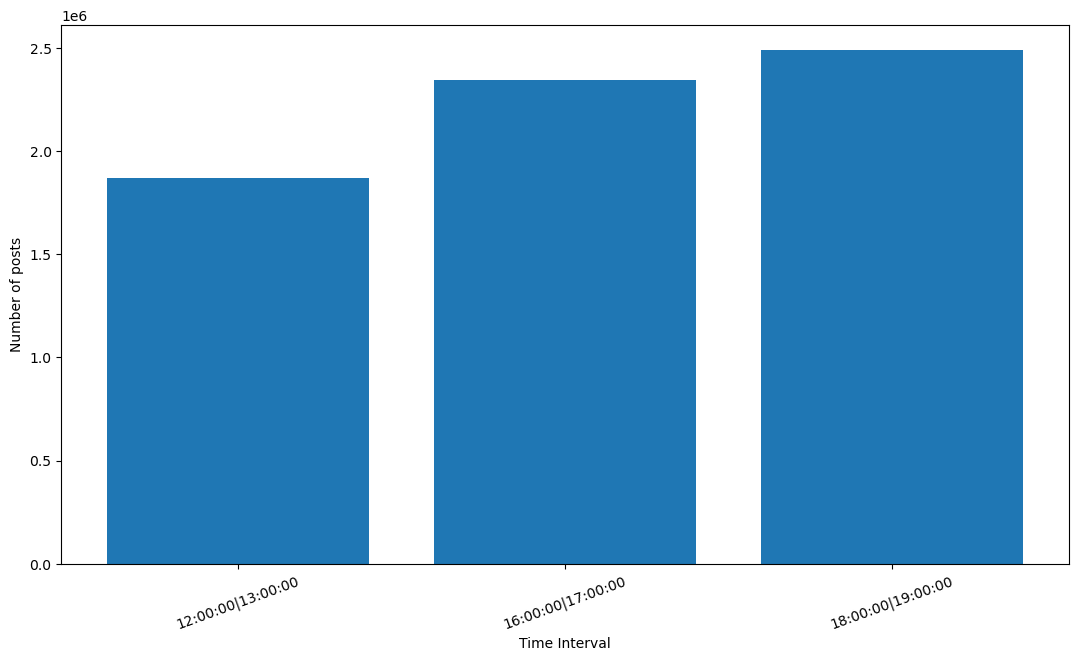

In [19]:
grouped_hourly_posts = posts[["cts", "numbr_likes", "number_comments"]].groupby(posts.cts.dt.hour)
likes_comments_hourly = grouped_hourly_posts.mean(numeric_only=True)

# Top 3 time intervals for likes
hours_best_like = likes_comments_hourly["numbr_likes"].sort_values(ascending=False).index[:3]
intervals_best_like = [(datetime.strptime(str(x), "%H.0").time(), (datetime.strptime(str(x), "%H.0") + timedelta(hours = 1)).time()) for x in hours_best_like]

# Top 3 time intervals for comments
hours_best_comment = likes_comments_hourly["number_comments"].sort_values(ascending=False).index[:3]
intervals_best_comment = [(datetime.strptime(str(x), "%H.0").time(), (datetime.strptime(str(x), "%H.0") + timedelta(hours = 1)).time()) for x in hours_best_comment]

# Plot number of posts for time intervals with the highest average number of likes
intervals_best_like.sort(key=lambda x:x[0])
time_interval_obs(intervals_best_like, posts)

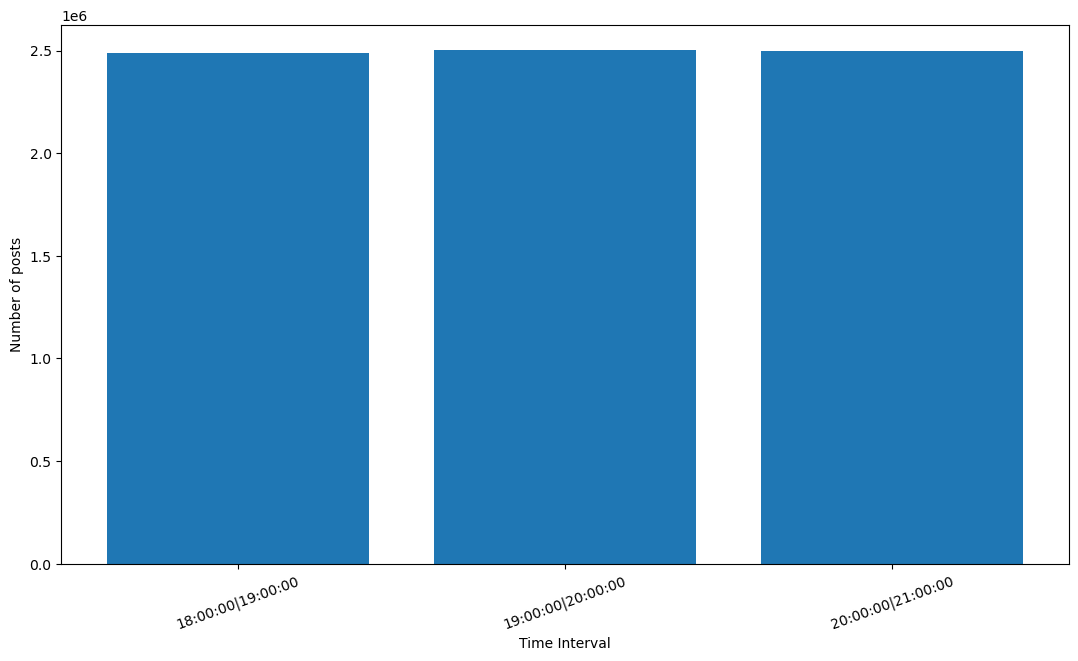

In [20]:
# Plot number of posts for time intervals with the highest average number of comments
intervals_best_comment.sort(key=lambda x:x[0])
time_interval_obs(intervals_best_comment, posts)

## RQ7
<a id = "rq7"></a>
### 7.1 What’s the probability that a post receives more than 20% “likes” of the number of followers a user has?
<a id = "rq7.1"></a>

The simplest way to think about this problem is simply considering the frequentist definition of the probability of an event, which would be $P(A) = \[ \lim_{N_T\to\infty} \frac{N_A}{N_T} \]$, where $N_T$ is the total number of observations and $N_A$ is the number of observations of the event $A$. Translated for this exercise, we need to compute the ratio between the number of posts receiving more likes than 20% of the number of followers and the total number of posts we have.

We use _sid_profile_ as the foreign key for the inner join between the posts table and the profile table. We need the inner join because we need to check also the number of followers.

In [5]:
#let's take smaller datasets from posts and profiles
#from profiles we are keeping only two columns ['profile_id', 'followers']
# from posts we are keeping only two columns ['profile_id','numbr_likes']
# merge the two dataframes

merged = pd.merge(posts.loc[:, ["sid_profile", "numbr_likes"]][posts.sid_profile != -1], profiles.loc[:, ["sid", "followers"]], left_on='sid_profile', right_on="sid", how='inner')

In [11]:
more_than_twenty = len(merged.loc[merged['numbr_likes'] > (0.2 * merged['followers'])])
prob = more_than_twenty / len(merged.followers)

print('The probability requested is: ', round(prob, 3))

The probability requested is:  0.151


### 7.2 Do users usually return to locations? Extract the probability that a user returns to a site after having posted it in the past.
<a id = "rq7.2"></a>

For what concerns the probability, the same concept explained in the previous answer holds here.
Since we do not need the information from the _profiles_ table, in this case we can use _profile_id_ as the profile identifier.

In [15]:
#taking only the useful columns ['profile_id','location_id']
#grouping-by the profile_id and location_id, and count how many times a location has been visited for each user
location_per_user = posts.iloc[:, [3, 4]].groupby(['profile_id', 'location_id']).location_id.count()
visited_more_than_once = len(location_per_user.loc[location_per_user > 1])

prob_requested = visited_more_than_once / len(location_per_user)
print("The probability that user will visit again the same location is: ", round(prob_requested, 4))

The probability that user will visit again the same location is:  0.1404


## RQ8
<a id = "rq8"></a>
### 8.1 Does more “likes” also mean more comments?
<a id = "rq8.1"></a>

As asked, to check the relationship between likes and comments we plot a scatterplot of the two variables. `plt.xlim` and `plt.ylim` are used in order to cut the axes and make the plot a bit more readable.

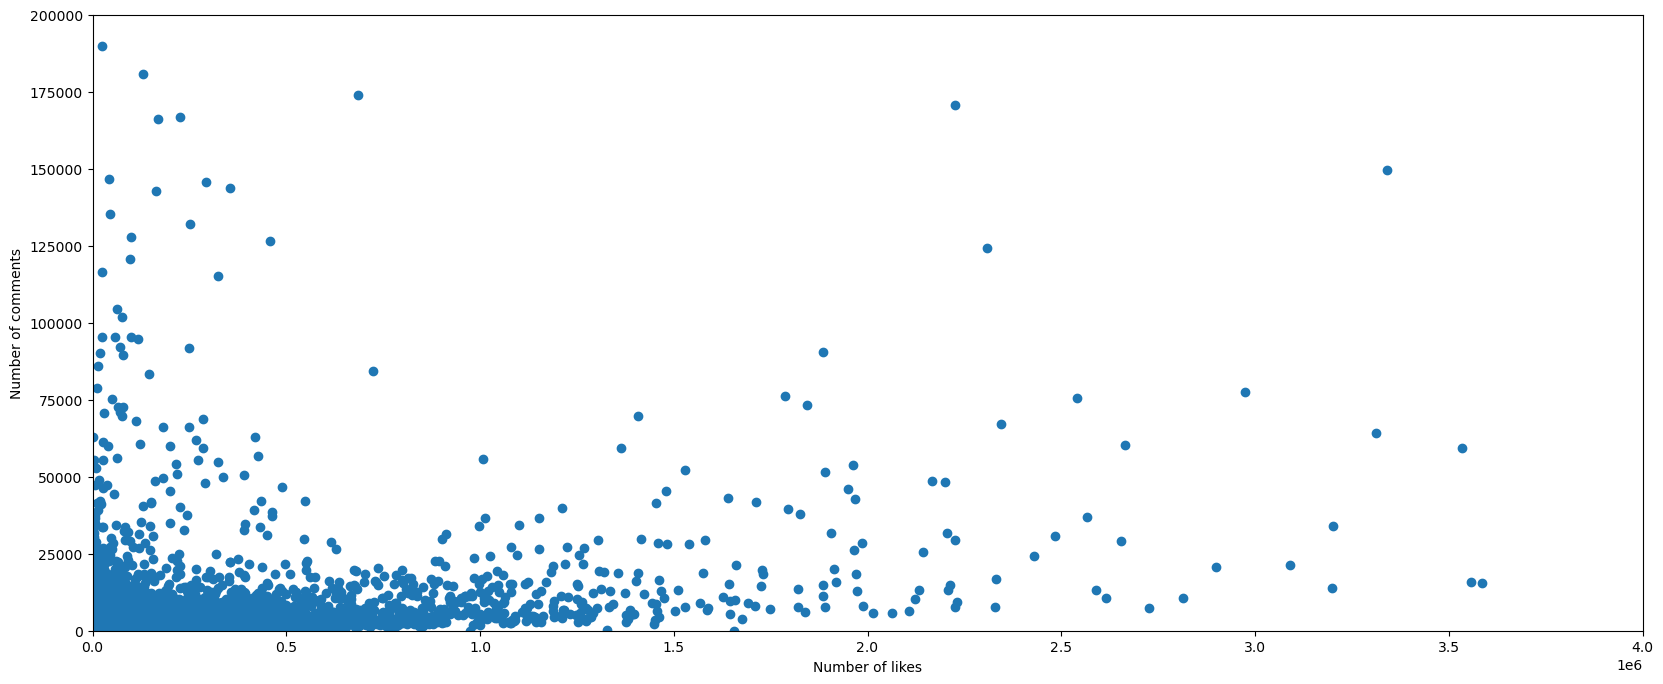

In [16]:
plt.figure(figsize=(20, 8))
plt.scatter(posts["numbr_likes"], posts["number_comments"])
plt.ylabel("Number of comments")
plt.xlabel("Number of likes")
plt.xlim([0, 4*10**6])
plt.ylim([0, 200000])
plt.show()

 A way to check the linear (only the linear) relationship would be to use **Pearson's correlation coefficient** (i.e. standardized covariance). Intuitively, the amount of covariance between (the numbers of) likes and comments cannot be zero, so it makes sense that the correlation coefficient is significant (0.37), albeit not high.

In [17]:
# By default Pandas computes Pearson
print("Pearson's Correlation coefficient for number of likes and the number of comments: {}".format(round(posts[["numbr_likes", "number_comments"]].corr().iloc[0, 1], 2)))

Pearson's Correlation coefficient for number of likes and the number of comments: 0.37


We could also check the relationship with a **linear regression**. We use the `polyfit` function from Numpy to do that. Notice also that we are retrieving the variance of the coefficients from the covariance matrix of the coefficients. This will be useful later on in order to do some **hypothesis testing**. We then plot the resulting line over the points.

We again use `plt.xlim` and `plt.ylim` to make everything more readable.

In [18]:
posts_complete_lc = posts[["numbr_likes", "number_comments"]].dropna()
coeff, covariance_matrix = np.polyfit(posts_complete_lc["numbr_likes"], posts_complete_lc["number_comments"], deg = 1, cov = "unscaled")
var1, var2 = covariance_matrix[[0, 1], [0, 1]]

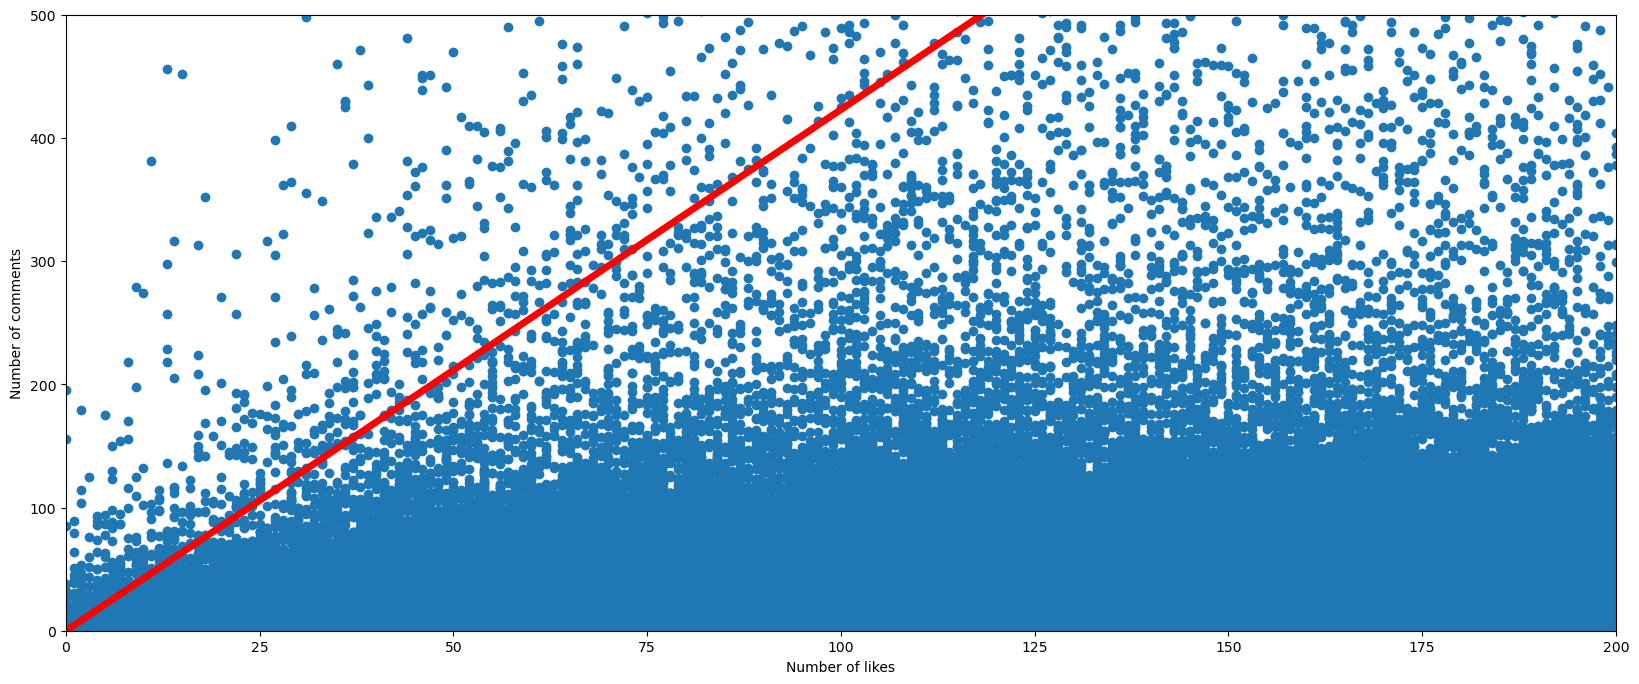

In [19]:
plt.figure(figsize=(20, 8))
ax = plt.gca()
ax.axline((0, coeff[0]), slope = coeff[1], linewidth = 5, c = "red")
ax.scatter(posts_complete_lc["numbr_likes"], posts_complete_lc["number_comments"])
plt.xlim([0, 200])
plt.xlabel("Number of likes")
plt.ylabel("Number of comments")
plt.ylim([0, 500])
plt.show()

 With the variances of the coefficients extracted before we can also return a p-value for the coefficients of the regression, the result of a simple t-test against the null hypothesis of the sampling distribution of the coefficients being a normal centered on zero. This in other words means that we are testing against the real value of the coefficients being zero.

More specifically, this stems from the fact that the coefficients are not random variables, in the same way the mean and the variance of a distribution are not random variables; their estimates are random variables, though. The mean of the distribution of their estimates (i.e. the sampling distribution) is the real value of the parameter.

 We assume homoscedasticity (since the covariance matrix of the coefficients uses the estimated variance of the residuals), which is a very unrealistic assumption in this case, but still. The t-distribution at this point is basically the normal (due to the very high number of degrees of freedom), so we can use that and disregard the t.

In [20]:
# Scipy is used for the CDF
print("p-value for intercept: {}".format(1-stats.norm.cdf((coeff[0]-0)/np.sqrt(var1))))
print("p-value for slope: {}".format(1-stats.norm.cdf((coeff[1]-0)/np.sqrt(var2))))

p-value for intercept: 0.0
p-value for slope: 0.0


### 8.2 Can you find any significant relationship between the time a user publishes a post and the number of comments and “likes”?
<a id = "rq8.2"></a>

Ok, this question is definitely tougher than the rest of the homework, especially if answered completely. So, let's get started.

The first thing to do is checking if the relationship between likes/comments per post and time exists or not. A way to check this, but there are others, is to use a $\chi^2$ test, assuming as our null hypothesis that the average number of likes per post and the average number of comments per post is homogeneous across time.

More formally speaking, this null hypothesis can be considered equivalent to this statement: the number of likes/comments per post in a timeframe (an hour of the day) is approximately normally distributed with mean given by the expected value assuming homogeneity across time, which would be the total number of likes/comments in the dataset divided by 24 and then normalized by the number of posts in the timeframe (an hour of the day).

If the null hypothesis holds, then the sum of these random variables (standardized and squared) is approximately modelled by a chi-squared with 23 degrees of freedom. In LaTex, the previous explanation is equivalent to this:

 $\sum_{h=1}^{24}\frac{\left(\frac{f_h}{n_h} - \frac{f_T}{24\cdot n_h}\right)^2}{\frac{f_T}{24 \cdot n_h}} = \sum_{h=1}^{24}\frac{\left(f_h - \frac{f_T}{24}\right)^2}{\frac{f_T}{24}\cdot n_h} \sim \chi_{23}^2$ \
\
where $n_h$ is the total number of posts in a specific hour, $f_T$ is the total number of comments/likes and $f_h$ is the total number of comments/likes in the specific hour.

Let's do this in practice with some code, and again using SciPy to get the CDF for the $\chi^2$.

In [22]:
# Let's do this in practice (likes)
number_of_posts_hour = posts.cts.dt.hour.value_counts().sort_index()
likes_per_hour = posts["numbr_likes"].groupby(posts.cts.dt.hour).sum().sort_index()
test_statistic_chi = (((likes_per_hour-(likes_per_hour.mean()))**2)/(likes_per_hour.mean()*number_of_posts_hour)).sum()
print("p-value for chi-squared test (likes): {}".format(1-stats.chi2.cdf(test_statistic_chi, 23)))
print(f"Test statistic for chi-squared test (likes): {round(test_statistic_chi, 2)}")

# Let's do this in practice (comments)
comments_per_hour = posts["number_comments"].groupby(posts.cts.dt.hour).sum().sort_index()
test_statistic_chi = (((comments_per_hour-(comments_per_hour.mean()))**2)/(comments_per_hour.mean()*number_of_posts_hour)).sum()
print("p-value for chi-squared test (comments): {}".format(1-stats.chi2.cdf(test_statistic_chi, 23)))
print(f"Test statistic for chi-squared test (comments): {round(test_statistic_chi, 2)}")

p-value for chi-squared test (likes): 0.0
Test statistic for chi-squared test (likes): 856.06
p-value for chi-squared test (comments): 0.5145157158320931
Test statistic for chi-squared test (comments): 22.1


It seems we can definitely reject our null hypothesis for likes (the p-value is practically 0): the number of likes per post seems definitely not independent of the hour/timeframe.

The contrary happens for what concerns the number of comments per post, for which we cannot reject the null: therefore we cannot state a dependence on the hour/timeframe. This is highlighted by a very small test statistic, very close to the expected value for a $\chi^2_{23}$, which is 23 (showing that is trivial).

 To check which kind of relationship we are talking about for what concerns the likes, let's do some overkill:  Fourier Regression!

Linear regression seems docile, but you can do literally whatever you want with the concept. One of the things is using a Fourier basis to transform the (single) predictor and fit a multivariate regression to estimate the Fourier coefficients. This is useful to estimate from real data the Fourier coefficients of an arbitrary periodic signal, such as the amount of likes during the day, something which we expect to be strongly periodic.

 Assuming that the period is even, like in this case, the expression of the model/of the Fourier series we have to fit is the one below.

$ f(x) = a_0 + \sum_{n = 1}^{N-1}\left(a_{n}\cdot cos\left(\frac{2\pi}{P}nx\right)+b_{n}\cdot sin\left(\frac{2\pi}{P}nx\right)\right) + a_N (-1)^x$ _with_ $N = \frac{P}{2} $
source: Time Series Analysis and its Applications, Fourth Edition, pg. 171 and Forecasting: Principles and Practice, [Chapter 7.4](https://otexts.com/fpp3/useful-predictors.html).

 We assume the day (24 hours, which is even) as the seasonal period and thus $\frac{1}{P}$ as the fundamental frequency of the series.

 Also notice that sines and cosine are orthonormal functions and sinusoidal waves of different frequencies are orthonormal, so the estimation of the coefficients should be pretty tame (since the predictors are uncorrelated and thus the variance of the coefficients does not skyrocket).

$x$ is the average number of likes per post in the specific hour, as can be seen in the lines of codes just below.

In [23]:
# Group by of the number of likes with hourly resolution
hourly_mean_likes = posts[["cts", "numbr_likes"]][posts["cts"]>"2013"].groupby(pd.Grouper(key = "cts", freq="H")).mean()

hourly_mean_likes["time_int"] = range(2, len(hourly_mean_likes)+2)
hourly_mean_likes.dropna(inplace=True)

Since we are fitting a model to explain periodicity (more properly, seasonality), we should first remove the trend component of the time series, if present. We can do that with a normal linear regression, using then the residuals from the regression as response for the harmonic regression.

We use _scikit-learn_ for the linear regression models necessary for this section.

In [25]:
# fit a linear regression to remove trend (if present)
# The residuals are then used to fit the harmonic regression
trend_regression = regression_sk(fit_intercept=True, copy_X=False)
trend_regression = trend_regression.fit(np.expand_dims(hourly_mean_likes.time_int, axis = 1), hourly_mean_likes.numbr_likes)
# Below, the residual vector aka fitted values vector
residual_vector = trend_regression.predict(np.expand_dims(hourly_mean_likes.time_int, axis=1))-hourly_mean_likes.numbr_likes

Now we need to fit the harmonic/Fourier regression, and in order to do that we first need to transform the original predictor, the time at hourly resolution. By transforming the time predictor (an integer representing a specific hour in time) we get a new design matrix for the regression.

After the transformation, we fit the actual model. We do not consider the intercept because it was already considered for the trend regression, and we are now fitting on its residuals.

We then plot the extracted periodic signal.

In [24]:
armonic_mult = range(1, 12)

fourier_design_matrix = [(np.cos((2*np.pi/24)* n * hourly_mean_likes.time_int.to_numpy()), np.sin((2*np.pi/24)* n * hourly_mean_likes.time_int.to_numpy())) for n in armonic_mult]

fourier_design_matrix = [x for t in fourier_design_matrix for x in t]
fourier_design_matrix.append(np.power(-1, hourly_mean_likes.time_int.to_numpy()))
fourier_design_matrix = np.column_stack(fourier_design_matrix)

In [26]:
fourier_regression = regression_sk(fit_intercept=False, copy_X=False)
fourier_regression = fourier_regression.fit(fourier_design_matrix, residual_vector)

In [27]:
# This function is necessary in order to plot the result
# it is necessary to map a series of integers (time indexes) to their predicted value, i.e. their value in the fitted series
def fourier_func(x:list[int], coeff:np.array, intercept:float, order:int, period:int) -> float:
    output_list = list()
    for time_index in x:
        output = 0
        for term_n in range(0, order-1):
            a, b = coeff[0+2*term_n], coeff[1+2*term_n]
            output += a*math.cos((2*math.pi/period)*(term_n+1)*time_index) + b*math.sin((2*math.pi/period)*(term_n+1)*time_index)
        output_list.append(output + intercept + coeff[-1]*(-1**time_index))
    return output_list

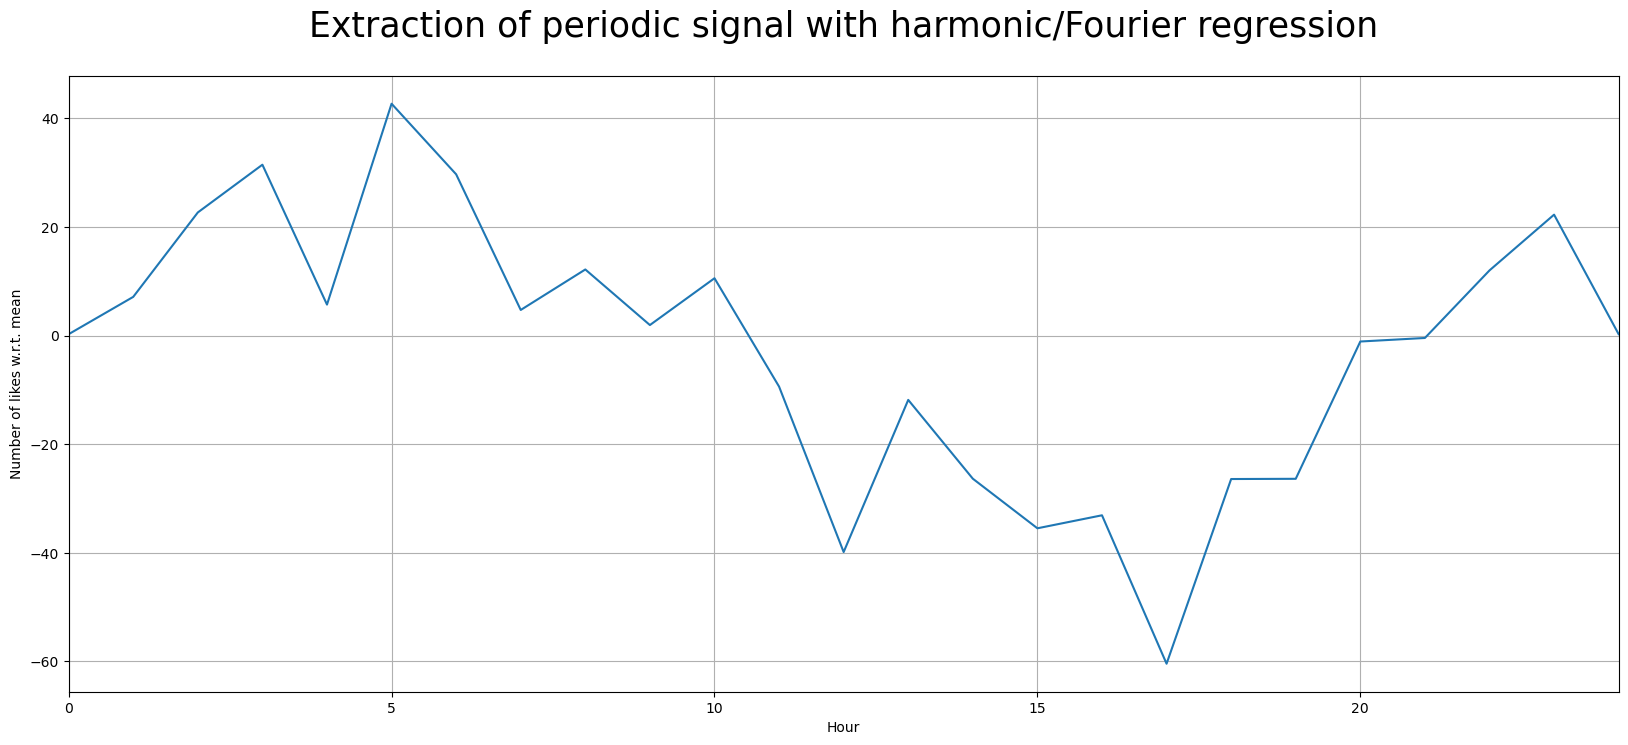

In [28]:
plt.figure(figsize=(20, 8))
plt.plot(list(range(0, 25)), fourier_func(list(range(0, 25)), fourier_regression.coef_, fourier_regression.intercept_, 12, 24))
plt.ylabel("Number of likes w.r.t. mean")
plt.xlabel("Hour")
plt.xlim((0, 24))
plt.grid(True)
plt.title("Extraction of periodic signal with harmonic/Fourier regression", fontdict={"fontsize": 25}, y = 1.05)
plt.show()

### 8.3 What’s the distribution of followers?
<a id = "rq8.3"></a>

As we did in [RQ1](#rq1.2), we compute basic summary statistics for the distribution + its mode (as required) + its skewness and kurtosis.

In [30]:
# print(profiles.followers.describe().iloc[1:].to_markdown())

print("Followers distro skewness: {}".format(profiles.followers.skew()))
print("Followers distro excess kurtosis: {}".format(profiles.followers.kurtosis()))
print("Followers distro mode: {}".format(profiles.followers.mode().values[0]))

Followers distro skewness: 959.7995044156165
Followers distro excess kurtosis: 1366535.2487827144
Followers distro mode: 0.0


|      |        followers |
|:-----|-----------------:|
| mean |   4739.9         |
| std  | 193909           |
| min  |      0           |
| 25%  |    159           |
| 50%  |    406           |
| 75%  |    974           |
| max  |      2.85458e+08 |

 This is an extremely distorted distro. Again, as we have explained in RQ1, this is due to preferential attachment processes underlying social networks dynamics, a concept which is even more intuitive, natural and clear when we think about the way profiles cluster in the directed social graph when looking at the edges/the follower connections. Intuitively, a new user is far more likely to follow a small set of users (VIPs) which have an already high number of followers, and this is basically the informal definition of a preferential attachment process.

High disparity in the network can be seen by the fact that the variable is log-normally distributed. We plot the histogram (which approximates the density) of the log-transformed variable and then a Q-Q to check normality of the log-transformed variable.

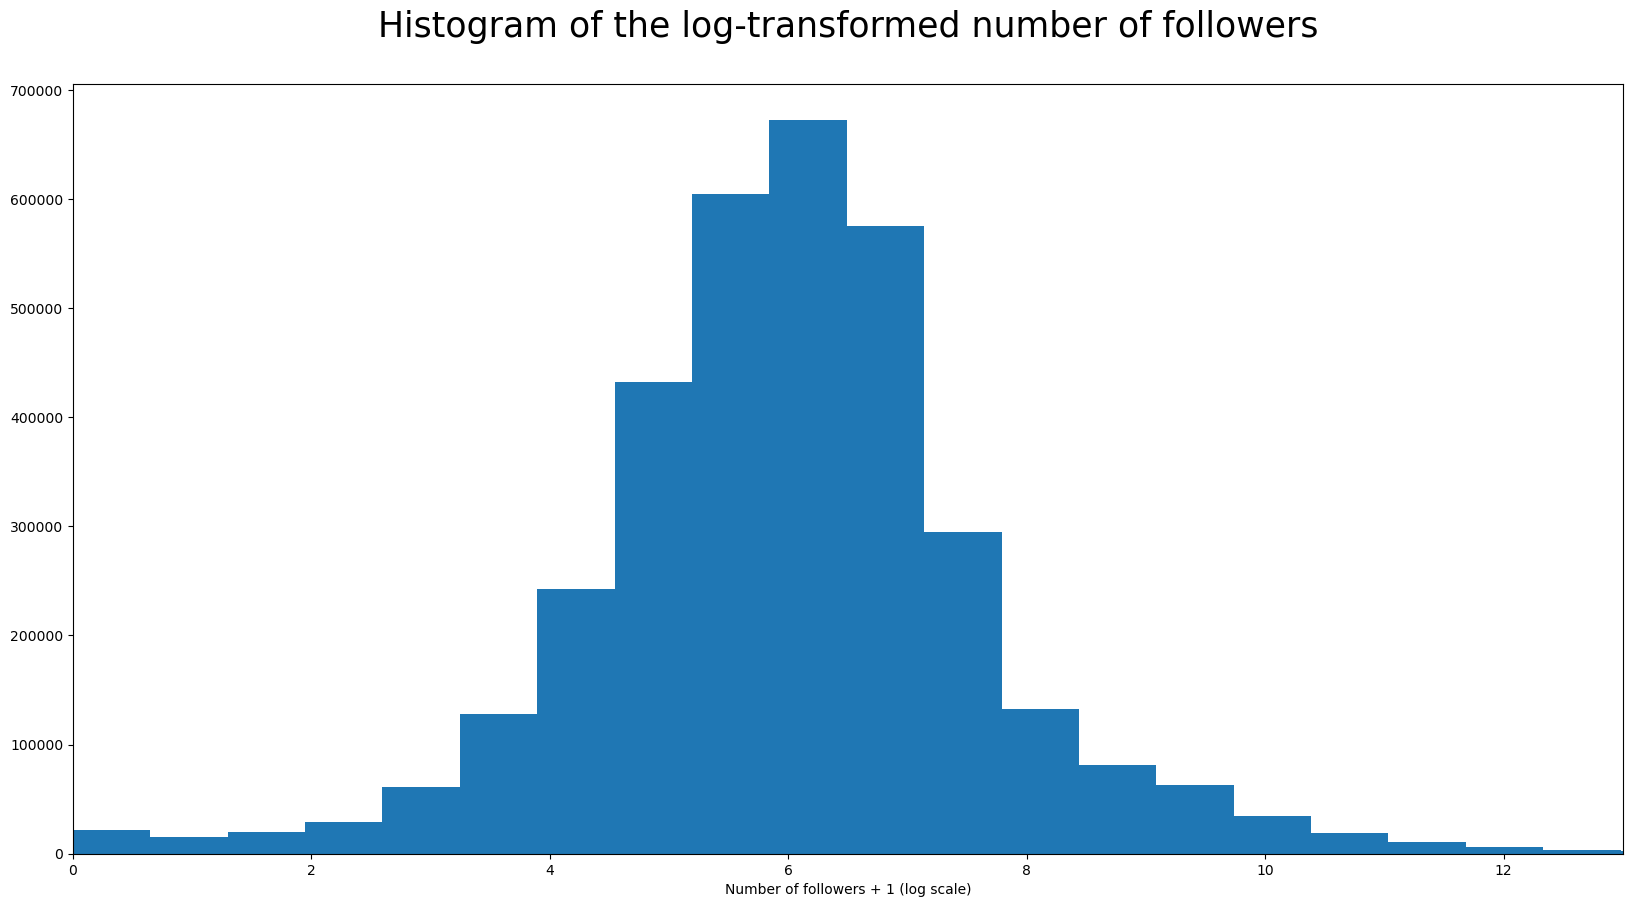

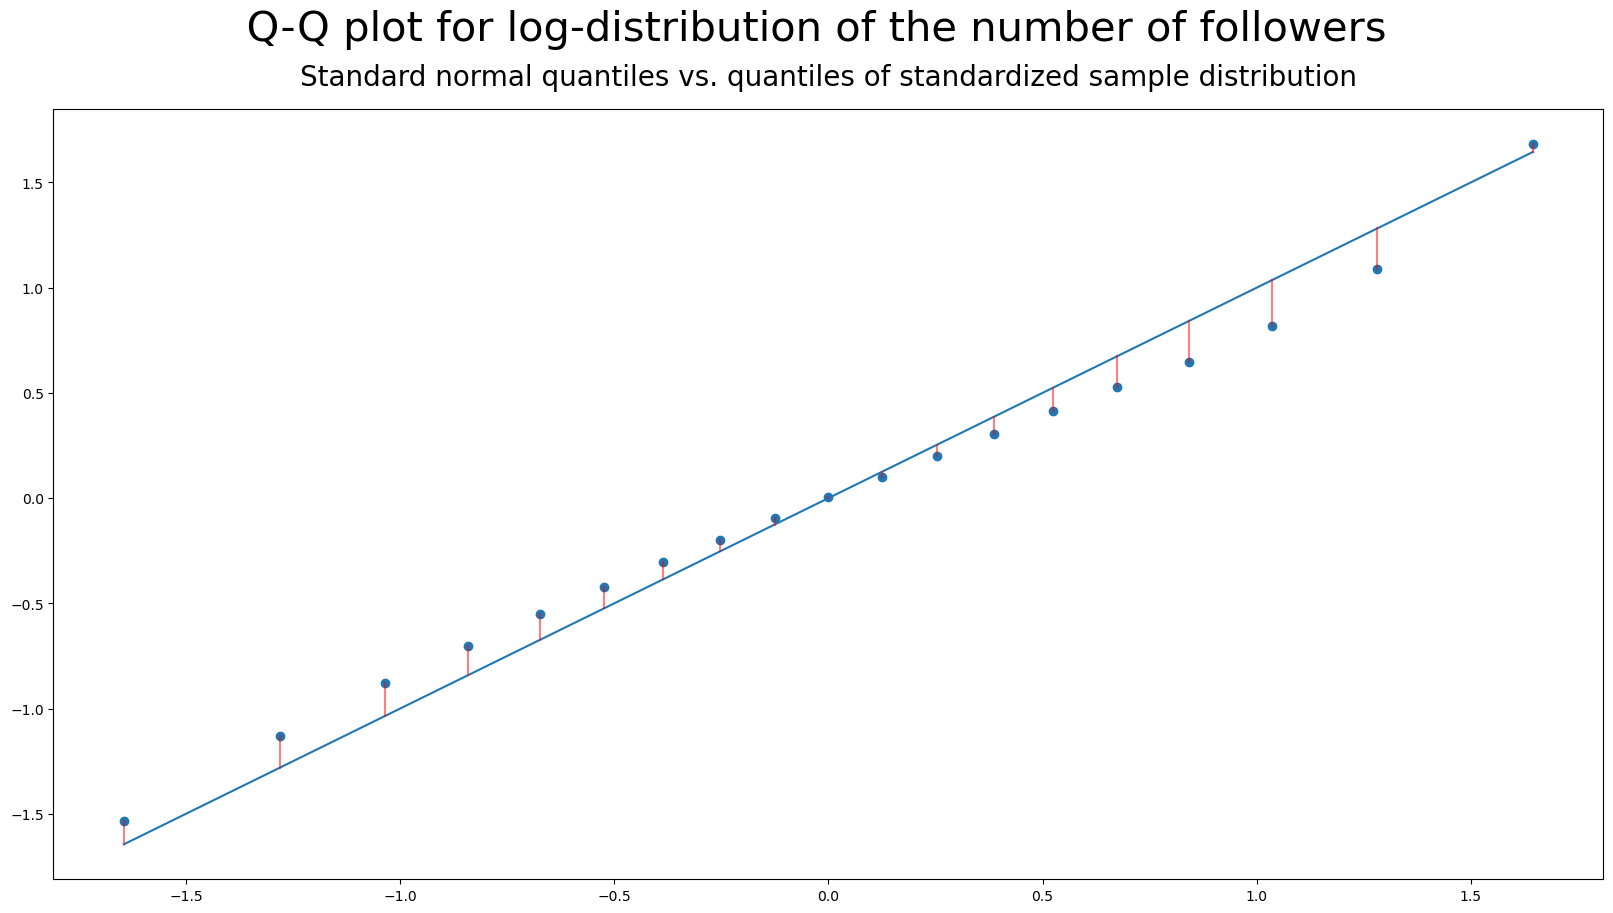

In [32]:
# Histogram
plt.figure(figsize=(20, 10))
plt.title("Histogram of the log-transformed number of followers", fontdict={"fontsize": 25}, y= 1.05)
plt.hist((profiles.followers+1).apply(np.log), bins=30)
plt.xlabel("Number of followers + 1 (log scale)")
plt.xlim(0, 13)
plt.show()

# Q-Q plot
quantiles_stdnorm = [stats.norm.ppf(x) for x in np.arange(0.05, 0.96, 0.05)]
log_transformed_followers = (profiles.followers+1).apply(np.log)
sample_quantiles_followers = ((log_transformed_followers-log_transformed_followers.mean())/log_transformed_followers.std()).quantile(np.arange(0.05, 0.96, 0.05))

plt.figure(figsize=(20, 10))
plt.suptitle("  Q-Q plot for log-distribution of the number of followers", fontsize = 30)
plt.title("Standard normal quantiles vs. quantiles of standardized sample distribution", fontsize = 20, y = 1.02)
ax = plt.gca()
ax.plot(quantiles_stdnorm, quantiles_stdnorm)
ax.scatter(quantiles_stdnorm, sample_quantiles_followers)
for standard, sample in zip(quantiles_stdnorm, sample_quantiles_followers):
    ax.plot([standard, standard], [standard, sample], c = "red", alpha = 0.5)
plt.show()

## AQ1
<a id = "aq1"></a>
### 1. What is the output of this algorithm? Describe the mechanism of the algorithm in detail.

In [33]:
def f1(sequence,end):
    for i in range(end):
        print(sequence[i])
    print('\n')
def f2(sequence,start,end):
    if start==end:
        f1(sequence,end)
    else:
        i= start
        while i<end:
            temp =  sequence[start]
            sequence[start] = sequence[i]
            sequence[i]  = temp
            f2(sequence,start+1,end)
            temp =  sequence[start]
            sequence[start] = sequence[i]
            sequence[i]  = temp
            i+=1

The output of this algorithm is the set of all permutations of a given sequence (List in this case) of length N.

Clearly there will be N! permutations, as can be seen in the case considered with N=3: in that case there will be 3!=3*2=6 permutations of the List string.

In [34]:
List = ['a','b','c']
N = 3
f2(List, 0, N)

a
b
c


a
c
b


b
a
c


b
c
a


c
b
a


c
a
b




At first the function f2(List,0,N) is called and since `start!=end` the function enters the while and the while loop is blocked because a recursive call to the function, `f2(List,0+1,N)`, is made.

Recursive cascade calls are then generated until `f2(List,N,N)` is called (of course at every call the List can change). A n-ary tree is generated and the leaves of this tree are the call at `f1(List,N)`. The function _f1_ will then print the list in N steps.




### 2. What is asymptotically (i.e., we are asking for big-O complexity) the algorithm's running time as a function of N?
<a id = "aq1.2"></a>

At the first level there is only 1 call to the function, and it's the first call to f2 with `start=0`.

At the second level there are _N_ calls to the function _f2_, everyone with `start=1`.

And so on, until we arrive at the _N-1_ level where there are _N!_ calls. In the last level there are _N!_ calls to the f1 function that will print all the permutations of the given sequence.

$$
\begin{aligned}
&T(N)=N T(N-1)+c\\
&T(N)=N[(N-1) T(N-2)+c]+c\\
&T(N)=N(N-1) T(N-2)+N c+c\\
&T(N)=N(N-1)[(N-2) T(N-3)+c]+N c+c\\
&T(N)=N(N-1)(N-2) T(N-3)+N(N-1) c+N c+c\\
&T(N)=N(N-1)(N-2) T(N-3)+c(1+N+N(N-1))\\
&T(N)=N !+c(1+N+N(N-1)+\cdots N(N-1)(N-2)\cdot \cdots\cdot4\cdot3)\\
&T(N)=N !+\left(\sum_{k=0}^{N-2} \frac{N !}{(N-k) !}\right) c=N !+\left(\sum_{k=0}^{N-2} \frac{1}{(N-k) !}\right) N!\cdot c\\
&O\left(N !+\left(\sum_{k=0}^{N-2} \frac{1}{(N-k) !}\right) N!\cdot c\right)=O(N !)\\
\end{aligned}
$$
so is an $$O(N !)$$
because the summation is not diverging and can be interpreted as a constant.\
Clearly to print a single permutation we need $$O(N).$$
So the given algorithm is an $$O(N\cdot N!).$$
<br><br>

### 3. Is this algorithm the optimal one to produce this output? If not, can you suggest a better algorithm to perform the same task?
<a id="aq1.3"></a>
The algorithm is optimal, since we know that all the permutation of a given sequence of lengh N are __N!__\
So we necessarily need __N!__ steps to create all the permutations(and of course for every permutation other __N__ operations).\
So since the problems is an $$O(N\cdot N!)$$ we can't find a better algorithm.

## AQ2